# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [1]:

# import os
# import string
#
# # 定义源目录路径
# source_dir = "EnglishHnd/EnglishHnd/English/Hnd/Img"
#
# # 生成目标文件夹名称列表
# target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]
#
# # 获取源目录下的所有文件夹名称
# source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])
#
# # 确保源文件夹数量与目标文件夹数量一致
# if len(source_folders) != len(target_folders):
#     raise ValueError("源文件夹数量与目标文件夹数量不一致")
#
# # 重命名文件夹
# for source_folder, target_folder in zip(source_folders, target_folders):
#     source_path = os.path.join(source_dir, source_folder)
#     target_path = os.path.join(source_dir, target_folder)
#
#     try:
#         os.rename(source_path, target_path)
#         print(f"重命名: {source_path} -> {target_path}")
#     except FileExistsError:
#         print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
#     except Exception as e:
#         print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")


### 划分训练集和测试集

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
from modelscope.utils.nlp.space.utils import f1_score

from myCnn.baseline.LeNet5 import LeNet5
from myCnn.train_model import train_model
from myCnn.utils import split_dataset
from myCnn.baseline.resnet18 import resnet18
from myCnn.baseline.mobilenet_v2 import mobilenet_v2
from myCnn.evaluate_model import evaluate_model
from myCnn.utils import plot_comparison
from myCnn.cnnWithAttention.attentionStructure import CNNWithAttention
from myCnn.cnnWithAttention.train_my_cnn import train_and_validate
EPOCH = 500
BATCH_SIZE = 128
LR = 1e-4

In [2]:
# # 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((64, 64)),
#     T.Grayscale(num_output_channels=3),
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(),
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])
class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(28, 28),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img)
        # img = np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()


训练集大小: 25900
验证集大小: 5550
测试集大小: 5550
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'a_': 26, 'b_': 27, 'd_': 28, 'e_': 29, 'f_': 30, 'g_': 31, 'h_': 32, 'n_': 33, 'q_': 34, 'r_': 35, 't_': 36}


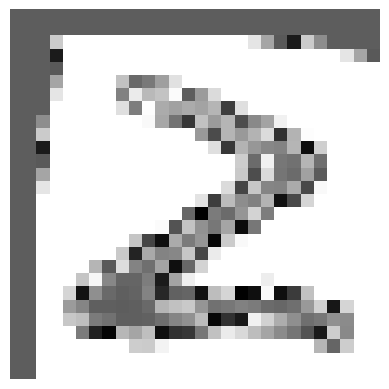

In [3]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="emnist_png_balanced",
    # root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)
print(full_dataset.class_to_idx)
# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()


# 获取类别数量
label_num = len(full_dataset.class_to_idx)

In [5]:

# # 获取展平后的训练集和验证集
# X_train, y_train = flatten_images(train_loader)
# X_val, y_val = flatten_images(val_loader)

In [6]:

# # 训练SVM模型
# svm_clf, train_acc, val_acc = train_svm(X_train, y_train, X_val, y_val)

In [4]:

# 初始化模型
resnet18 = resnet18(num_classes=label_num)
mobilenet_v2 = mobilenet_v2(num_classes=label_num)
LeNet5 = LeNet5(num_classes=label_num)


# 加载最好的权重模型

resnet18.load_state_dict(torch.load('best_model_resnet18.pth'))
mobilenet_v2.load_state_dict(torch.load('best_model_mobilenet_v2.pth'))
LeNet5.load_state_dict(torch.load('best_model_LeNet5.pth'))


# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)  # 将模型迁移到 GPU
mobilenet_v2.to(device)
LeNet5.to(device)



LeNet5(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): LazyLinear(in_features=0, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=37, bias=True)
  )
)

In [5]:

# 假设使用cpu
# cnn.to('cpu')

# 创建优化器
optimizer_resnet18 = torch.optim.AdamW(resnet18.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_mobilenet_v2 = torch.optim.AdamW(mobilenet_v2.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_LeNet5 = torch.optim.AdamW(LeNet5.parameters(), lr=3e-4, weight_decay=0.05)



# 定义损失函数
loss_func = nn.CrossEntropyLoss()

🔍 特征图钩子已注册到: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


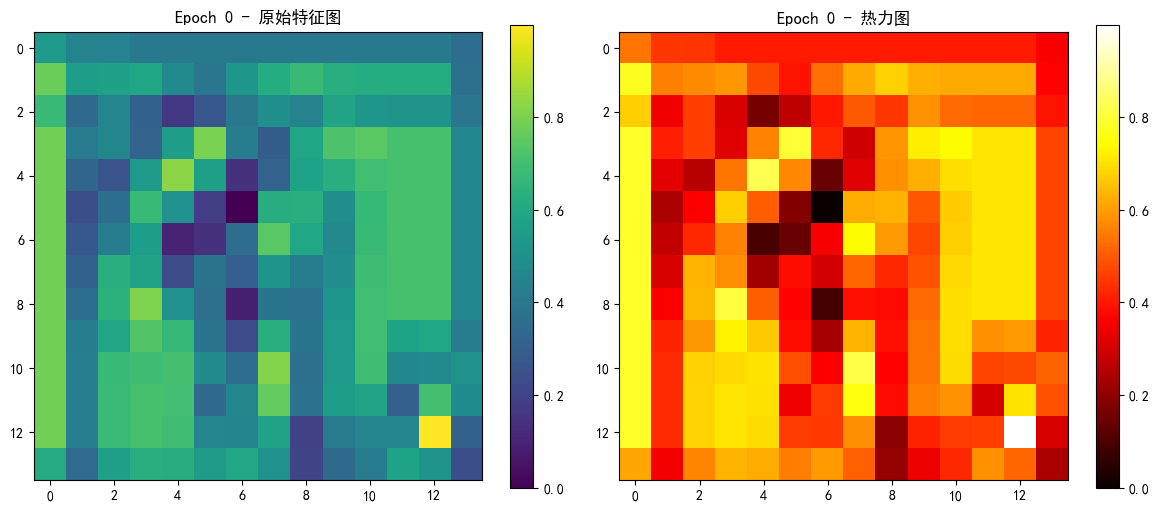

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_0.png
🎯 新最佳模型 (准确率: 0.7809) 已保存到 best_model_resnet18.pth
Epoch 1/500: Train Loss: 1.5927 | Val Loss: 0.7382 | Train Top-1: 0.5741 | Val Top-1: 0.7809 | Train Top-3: 0.7724 | Val Top-3: 0.9339
🎯 新最佳模型 (准确率: 0.8454) 已保存到 best_model_resnet18.pth
Epoch 2/500: Train Loss: 0.5933 | Val Loss: 0.4993 | Train Top-1: 0.8181 | Val Top-1: 0.8454 | Train Top-3: 0.9555 | Val Top-3: 0.9645
🎯 新最佳模型 (准确率: 0.8647) 已保存到 best_model_resnet18.pth
Epoch 3/500: Train Loss: 0.4413 | Val Loss: 0.4275 | Train Top-1: 0.8610 | Val Top-1: 0.8647 | Train Top-3: 0.9721 | Val Top-3: 0.9724
🎯 新最佳模型 (准确率: 0.8723) 已保存到 best_model_resnet18.pth
Epoch 4/500: Train Loss: 0.3649 | Val Loss: 0.3830 | Train Top-1: 0.8831 | Val Top-1: 0.8723 | Train Top-3: 0.9803 | Val Top-3: 0.9800
🎯 新最佳模型 (准确率: 0.8764) 已保存到 best_model_resnet18.pth
Epoch 5/500: Train Loss: 0.3246 | Val Loss: 0.3698 | Train Top-1: 0.8925 | Val Top-1: 0.8764 | Train Top-3: 0.9842 | Val Top-3: 0.9798


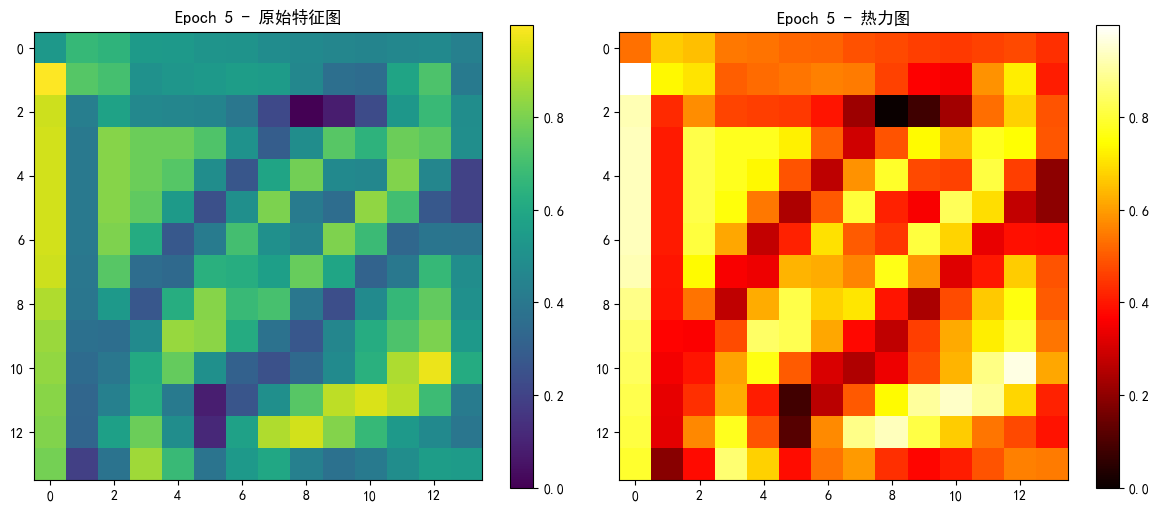

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_5.png
🎯 新最佳模型 (准确率: 0.8834) 已保存到 best_model_resnet18.pth
Epoch 6/500: Train Loss: 0.2950 | Val Loss: 0.3415 | Train Top-1: 0.9016 | Val Top-1: 0.8834 | Train Top-3: 0.9878 | Val Top-3: 0.9829
🎯 新最佳模型 (准确率: 0.8879) 已保存到 best_model_resnet18.pth
Epoch 7/500: Train Loss: 0.2683 | Val Loss: 0.3335 | Train Top-1: 0.9086 | Val Top-1: 0.8879 | Train Top-3: 0.9895 | Val Top-3: 0.9825
🎯 新最佳模型 (准确率: 0.8912) 已保存到 best_model_resnet18.pth
Epoch 8/500: Train Loss: 0.2460 | Val Loss: 0.3212 | Train Top-1: 0.9163 | Val Top-1: 0.8912 | Train Top-3: 0.9918 | Val Top-3: 0.9850
🎯 新最佳模型 (准确率: 0.8932) 已保存到 best_model_resnet18.pth
Epoch 9/500: Train Loss: 0.2372 | Val Loss: 0.3201 | Train Top-1: 0.9173 | Val Top-1: 0.8932 | Train Top-3: 0.9925 | Val Top-3: 0.9867
Epoch 10/500: Train Loss: 0.2221 | Val Loss: 0.3265 | Train Top-1: 0.9212 | Val Top-1: 0.8914 | Train Top-3: 0.9938 | Val Top-3: 0.9849


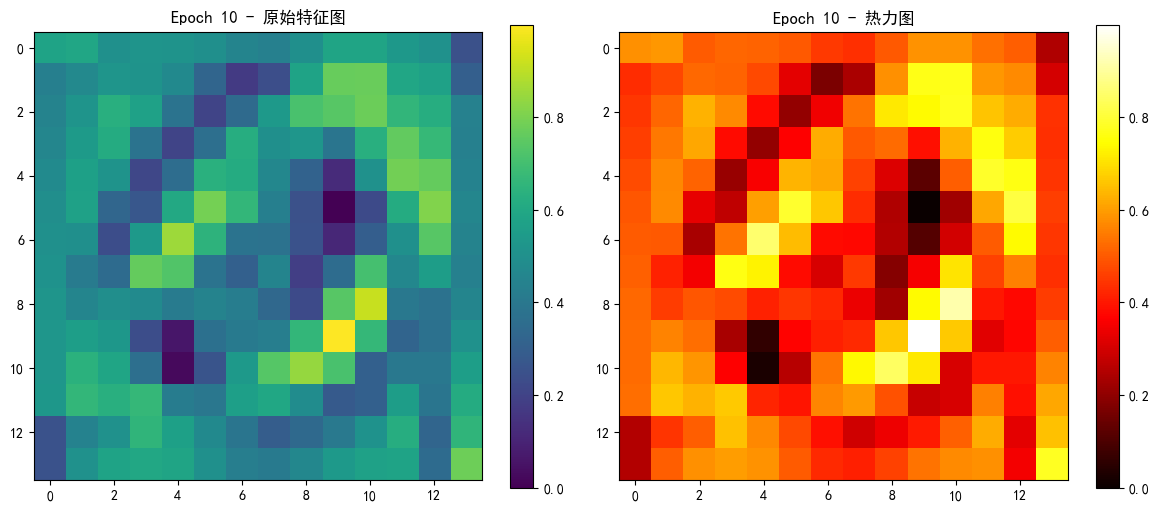

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_10.png
🎯 新最佳模型 (准确率: 0.8946) 已保存到 best_model_resnet18.pth
Epoch 11/500: Train Loss: 0.2120 | Val Loss: 0.3142 | Train Top-1: 0.9236 | Val Top-1: 0.8946 | Train Top-3: 0.9946 | Val Top-3: 0.9867
Epoch 12/500: Train Loss: 0.1936 | Val Loss: 0.3187 | Train Top-1: 0.9306 | Val Top-1: 0.8899 | Train Top-3: 0.9953 | Val Top-3: 0.9872
Epoch 13/500: Train Loss: 0.1826 | Val Loss: 0.3180 | Train Top-1: 0.9344 | Val Top-1: 0.8924 | Train Top-3: 0.9961 | Val Top-3: 0.9863
🎯 新最佳模型 (准确率: 0.8969) 已保存到 best_model_resnet18.pth
Epoch 14/500: Train Loss: 0.1719 | Val Loss: 0.3106 | Train Top-1: 0.9378 | Val Top-1: 0.8969 | Train Top-3: 0.9969 | Val Top-3: 0.9865
Epoch 15/500: Train Loss: 0.1744 | Val Loss: 0.3126 | Train Top-1: 0.9368 | Val Top-1: 0.8969 | Train Top-3: 0.9972 | Val Top-3: 0.9872


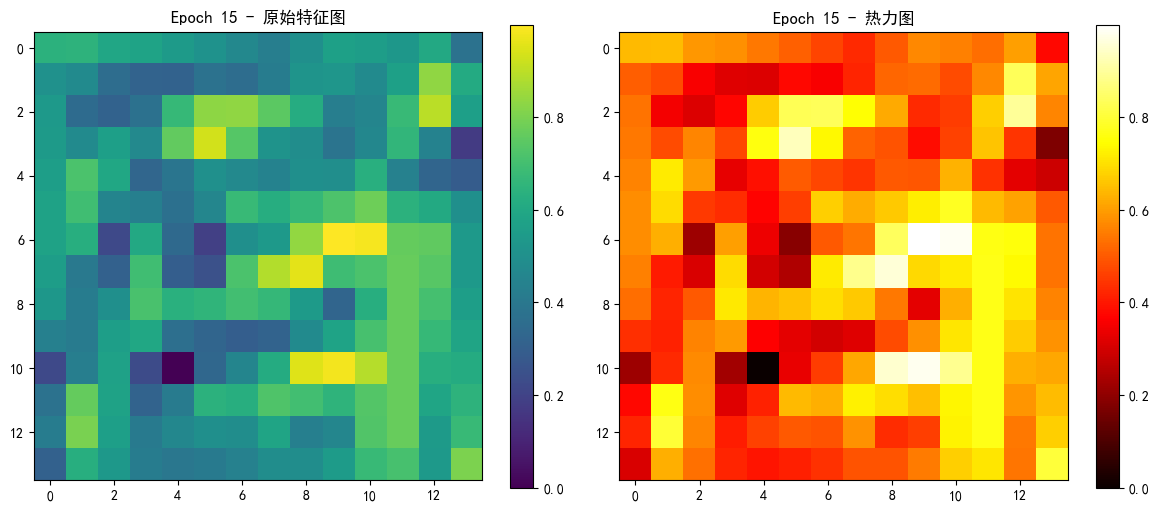

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_15.png
🎯 新最佳模型 (准确率: 0.9025) 已保存到 best_model_resnet18.pth
Epoch 16/500: Train Loss: 0.1600 | Val Loss: 0.3028 | Train Top-1: 0.9411 | Val Top-1: 0.9025 | Train Top-3: 0.9980 | Val Top-3: 0.9870
Epoch 17/500: Train Loss: 0.1561 | Val Loss: 0.3001 | Train Top-1: 0.9415 | Val Top-1: 0.8996 | Train Top-3: 0.9979 | Val Top-3: 0.9863
Epoch 18/500: Train Loss: 0.1564 | Val Loss: 0.3069 | Train Top-1: 0.9413 | Val Top-1: 0.8987 | Train Top-3: 0.9983 | Val Top-3: 0.9872
🎯 新最佳模型 (准确率: 0.9032) 已保存到 best_model_resnet18.pth
Epoch 19/500: Train Loss: 0.1453 | Val Loss: 0.3067 | Train Top-1: 0.9448 | Val Top-1: 0.9032 | Train Top-3: 0.9982 | Val Top-3: 0.9867
Epoch 20/500: Train Loss: 0.1350 | Val Loss: 0.3102 | Train Top-1: 0.9493 | Val Top-1: 0.8969 | Train Top-3: 0.9983 | Val Top-3: 0.9861


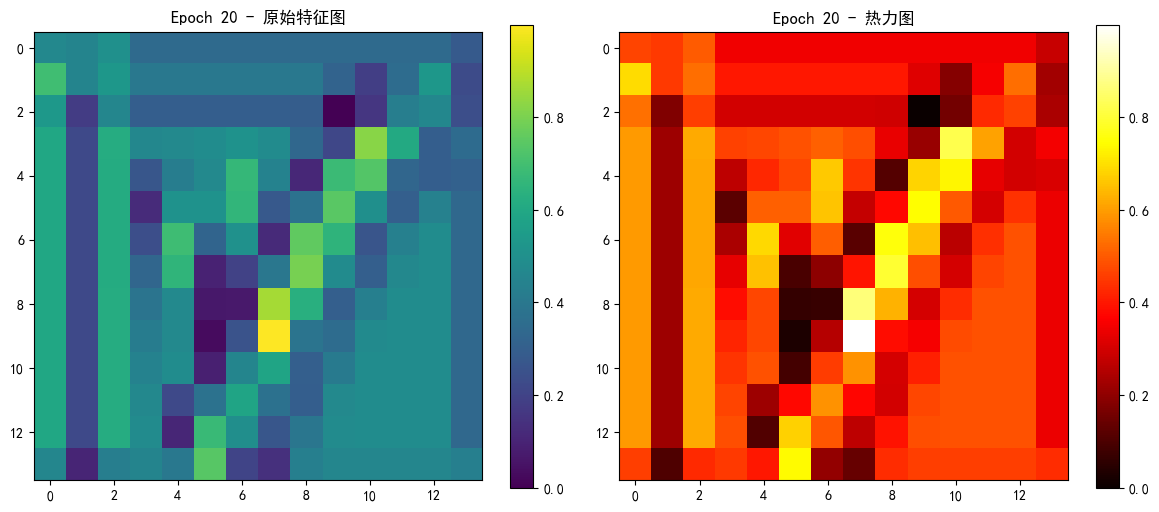

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_20.png
Epoch 21/500: Train Loss: 0.1364 | Val Loss: 0.3193 | Train Top-1: 0.9466 | Val Top-1: 0.8957 | Train Top-3: 0.9984 | Val Top-3: 0.9858
Epoch 22/500: Train Loss: 0.1329 | Val Loss: 0.3192 | Train Top-1: 0.9484 | Val Top-1: 0.8993 | Train Top-3: 0.9992 | Val Top-3: 0.9877
🎯 新最佳模型 (准确率: 0.9056) 已保存到 best_model_resnet18.pth
Epoch 23/500: Train Loss: 0.1325 | Val Loss: 0.3036 | Train Top-1: 0.9496 | Val Top-1: 0.9056 | Train Top-3: 0.9984 | Val Top-3: 0.9874
Epoch 24/500: Train Loss: 0.1271 | Val Loss: 0.3159 | Train Top-1: 0.9515 | Val Top-1: 0.9009 | Train Top-3: 0.9989 | Val Top-3: 0.9872
Epoch 25/500: Train Loss: 0.1220 | Val Loss: 0.3190 | Train Top-1: 0.9530 | Val Top-1: 0.8982 | Train Top-3: 0.9990 | Val Top-3: 0.9872


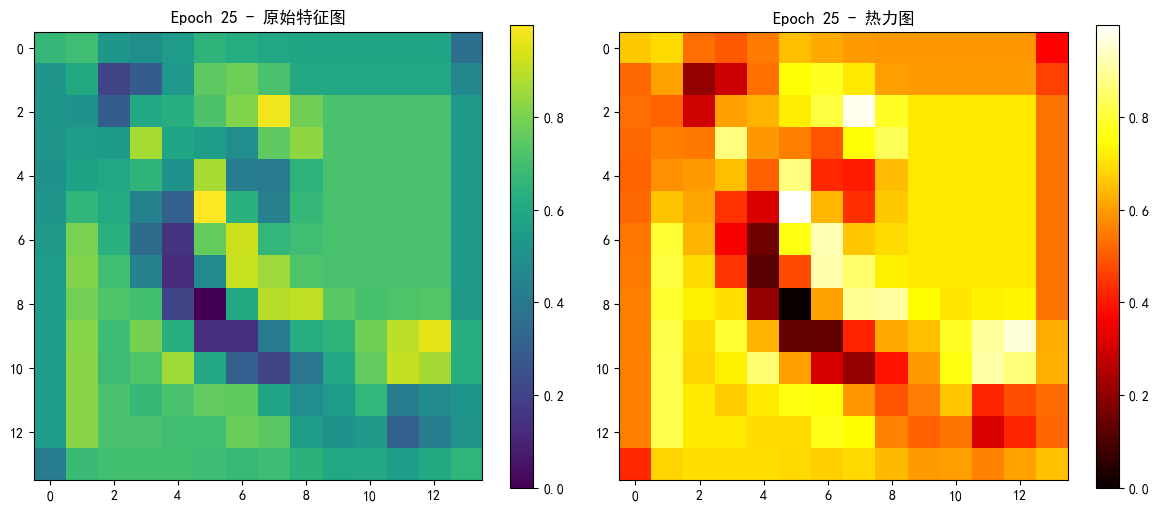

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_25.png
Epoch 26/500: Train Loss: 0.1206 | Val Loss: 0.3169 | Train Top-1: 0.9532 | Val Top-1: 0.9036 | Train Top-3: 0.9991 | Val Top-3: 0.9870
Epoch 27/500: Train Loss: 0.1238 | Val Loss: 0.3208 | Train Top-1: 0.9528 | Val Top-1: 0.8998 | Train Top-3: 0.9990 | Val Top-3: 0.9870
🎯 新最佳模型 (准确率: 0.9072) 已保存到 best_model_resnet18.pth
Epoch 28/500: Train Loss: 0.1160 | Val Loss: 0.2919 | Train Top-1: 0.9548 | Val Top-1: 0.9072 | Train Top-3: 0.9993 | Val Top-3: 0.9895
Epoch 29/500: Train Loss: 0.1072 | Val Loss: 0.3144 | Train Top-1: 0.9585 | Val Top-1: 0.9063 | Train Top-3: 0.9994 | Val Top-3: 0.9897
Epoch 30/500: Train Loss: 0.1092 | Val Loss: 0.3261 | Train Top-1: 0.9576 | Val Top-1: 0.9020 | Train Top-3: 0.9992 | Val Top-3: 0.9867


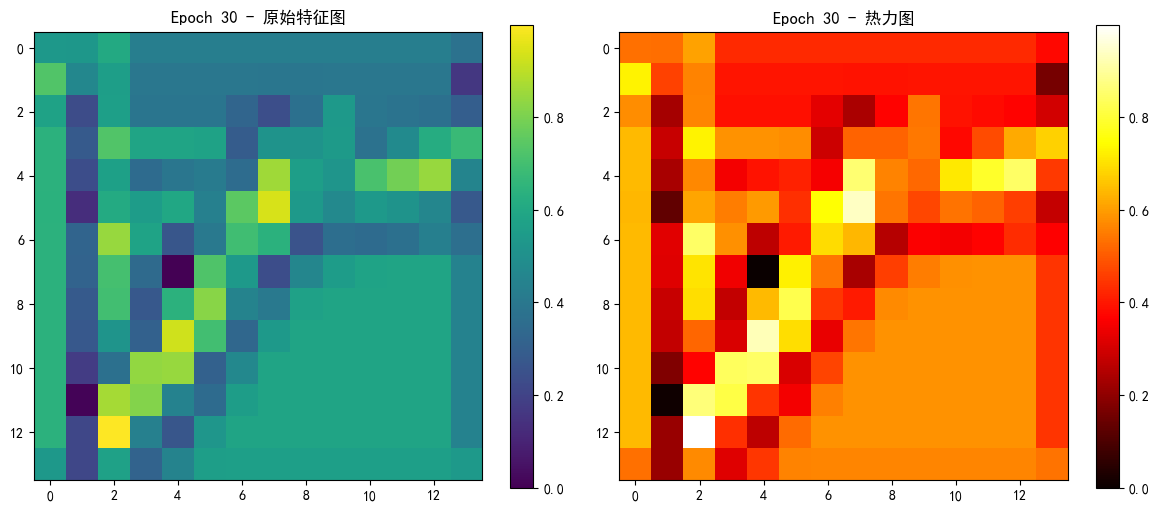

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_30.png
Epoch 31/500: Train Loss: 0.1025 | Val Loss: 0.3126 | Train Top-1: 0.9605 | Val Top-1: 0.9056 | Train Top-3: 0.9993 | Val Top-3: 0.9895
Epoch 32/500: Train Loss: 0.1012 | Val Loss: 0.3214 | Train Top-1: 0.9603 | Val Top-1: 0.9043 | Train Top-3: 0.9993 | Val Top-3: 0.9888
Epoch 33/500: Train Loss: 0.0998 | Val Loss: 0.3299 | Train Top-1: 0.9614 | Val Top-1: 0.9011 | Train Top-3: 0.9993 | Val Top-3: 0.9897
🎯 新最佳模型 (准确率: 0.9083) 已保存到 best_model_resnet18.pth
Epoch 34/500: Train Loss: 0.1045 | Val Loss: 0.3117 | Train Top-1: 0.9601 | Val Top-1: 0.9083 | Train Top-3: 0.9995 | Val Top-3: 0.9890
Epoch 35/500: Train Loss: 0.0987 | Val Loss: 0.3176 | Train Top-1: 0.9619 | Val Top-1: 0.9034 | Train Top-3: 0.9995 | Val Top-3: 0.9903


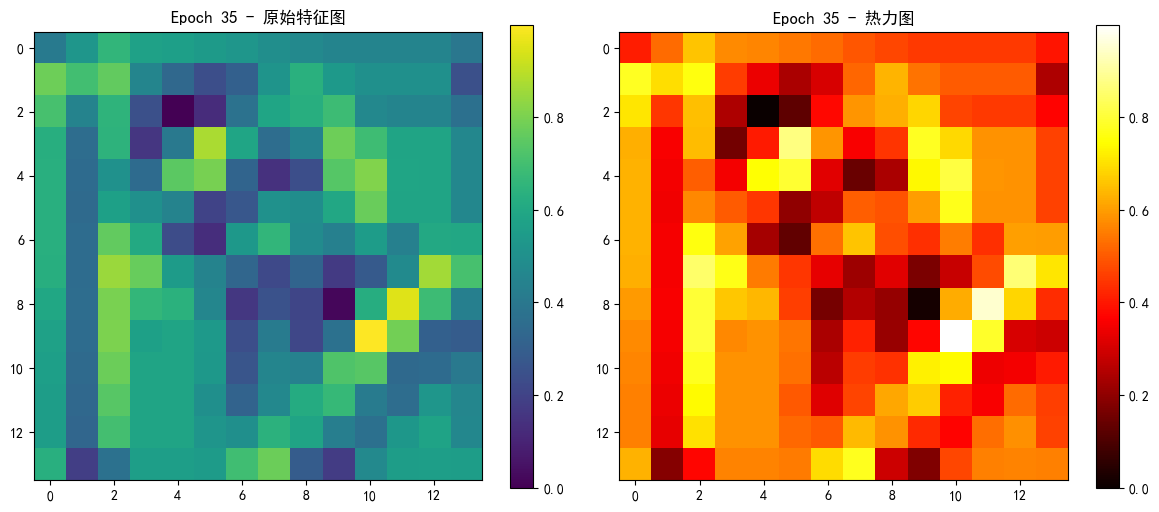

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_35.png
Epoch 36/500: Train Loss: 0.0937 | Val Loss: 0.3154 | Train Top-1: 0.9637 | Val Top-1: 0.9061 | Train Top-3: 0.9995 | Val Top-3: 0.9867
Epoch 37/500: Train Loss: 0.0953 | Val Loss: 0.3342 | Train Top-1: 0.9640 | Val Top-1: 0.8991 | Train Top-3: 0.9995 | Val Top-3: 0.9876
Epoch 38/500: Train Loss: 0.0904 | Val Loss: 0.3304 | Train Top-1: 0.9649 | Val Top-1: 0.9061 | Train Top-3: 0.9994 | Val Top-3: 0.9897
Epoch 39/500: Train Loss: 0.0861 | Val Loss: 0.3201 | Train Top-1: 0.9664 | Val Top-1: 0.9076 | Train Top-3: 0.9997 | Val Top-3: 0.9895
Epoch 40/500: Train Loss: 0.0877 | Val Loss: 0.3413 | Train Top-1: 0.9653 | Val Top-1: 0.9027 | Train Top-3: 0.9997 | Val Top-3: 0.9854


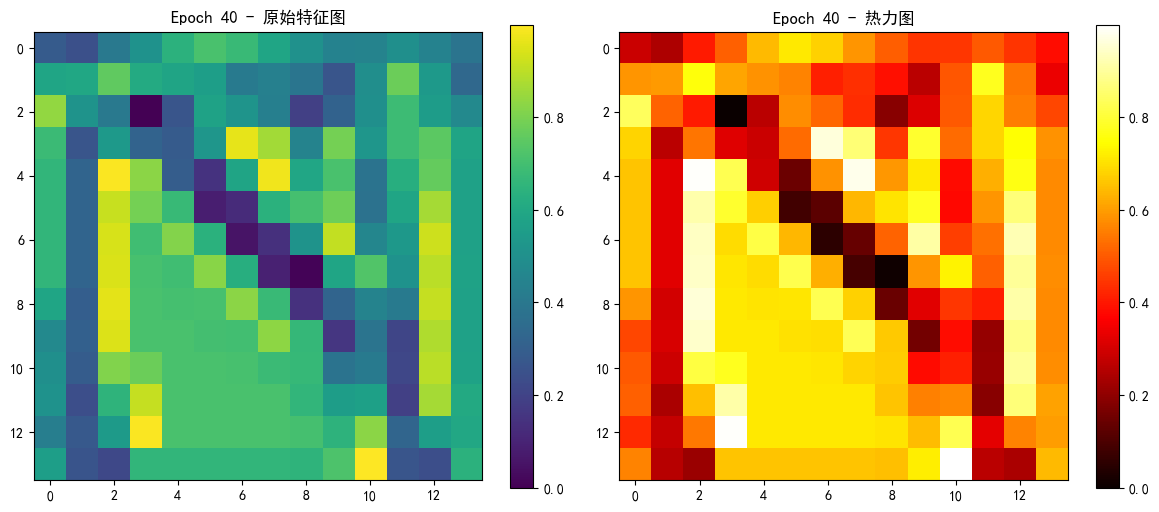

🖼️ 特征图已保存到: runs/20250424_160954\feature_map_epoch_40.png
Epoch 41/500: Train Loss: 0.0857 | Val Loss: 0.3209 | Train Top-1: 0.9670 | Val Top-1: 0.9041 | Train Top-3: 0.9995 | Val Top-3: 0.9897
Epoch 42/500: Train Loss: 0.0822 | Val Loss: 0.3444 | Train Top-1: 0.9682 | Val Top-1: 0.9020 | Train Top-3: 0.9995 | Val Top-3: 0.9892
Epoch 43/500: Train Loss: 0.0819 | Val Loss: 0.3511 | Train Top-1: 0.9675 | Val Top-1: 0.8986 | Train Top-3: 0.9997 | Val Top-3: 0.9854
⏹️ 早停触发: 验证准确率连续 10 轮未提升
✅ 特征图钩子已移除


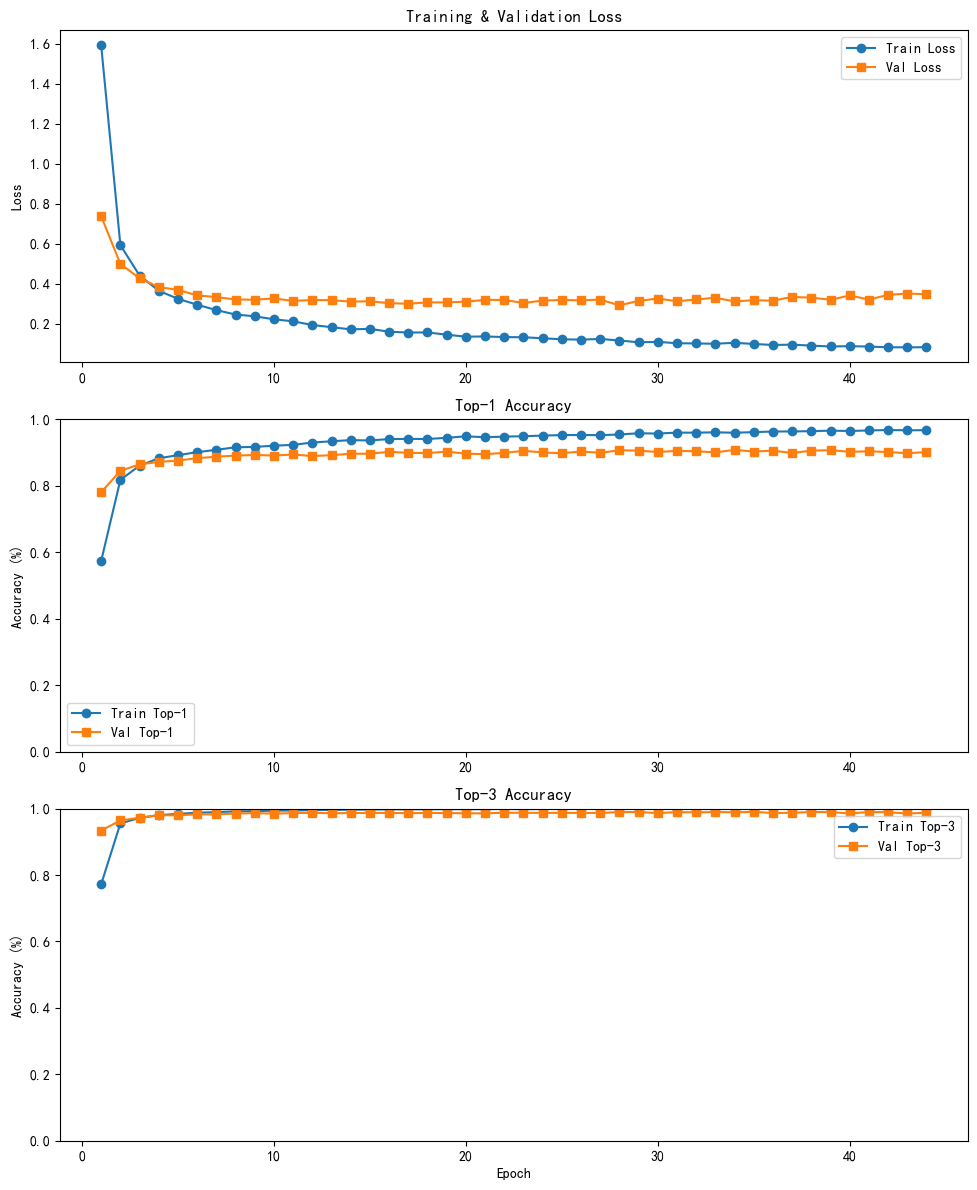

📊 训练图表已保存到: training_plots\training_metrics_20250424_162156.png


In [9]:
# 训练模型
resnet18 = train_and_validate(model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_resnet18.pth",
    lr=LR)


🔍 特征图钩子已注册到: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


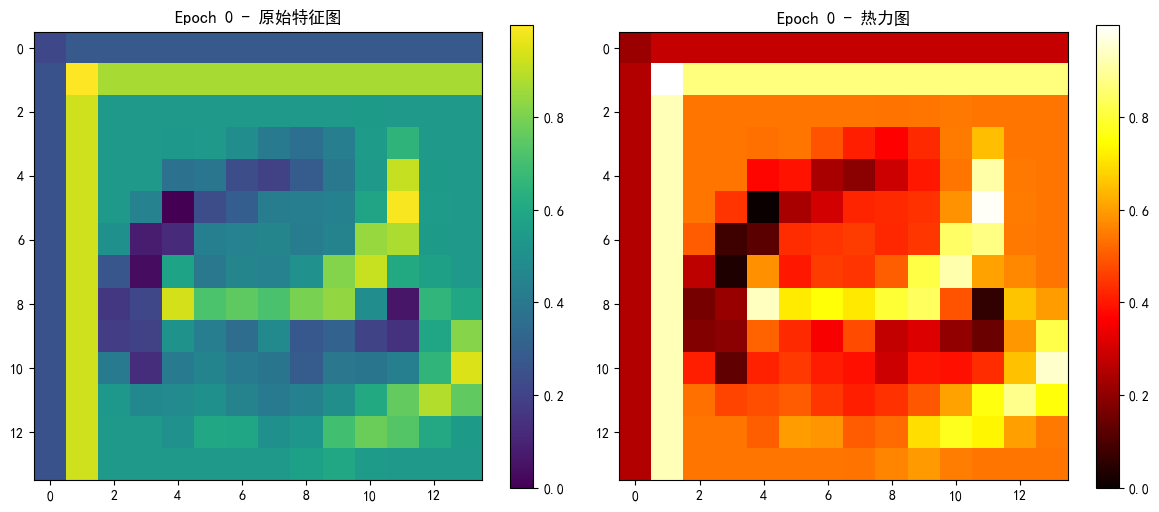

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_0.png
🎯 新最佳模型 (准确率: 0.0895) 已保存到 best_model_mobilenet_v2.pth
Epoch 1/500: Train Loss: 3.5486 | Val Loss: 3.3725 | Train Top-1: 0.0514 | Val Top-1: 0.0895 | Train Top-3: 0.1407 | Val Top-3: 0.2290
🎯 新最佳模型 (准确率: 0.1863) 已保存到 best_model_mobilenet_v2.pth
Epoch 2/500: Train Loss: 3.1564 | Val Loss: 2.8781 | Train Top-1: 0.1305 | Val Top-1: 0.1863 | Train Top-3: 0.3020 | Val Top-3: 0.3960
🎯 新最佳模型 (准确率: 0.2933) 已保存到 best_model_mobilenet_v2.pth
Epoch 3/500: Train Loss: 2.7021 | Val Loss: 2.4203 | Train Top-1: 0.2275 | Val Top-1: 0.2933 | Train Top-3: 0.4588 | Val Top-3: 0.5598
🎯 新最佳模型 (准确率: 0.3908) 已保存到 best_model_mobilenet_v2.pth
Epoch 4/500: Train Loss: 2.2624 | Val Loss: 2.0353 | Train Top-1: 0.3302 | Val Top-1: 0.3908 | Train Top-3: 0.6054 | Val Top-3: 0.6755
🎯 新最佳模型 (准确率: 0.4879) 已保存到 best_model_mobilenet_v2.pth
Epoch 5/500: Train Loss: 1.9017 | Val Loss: 1.7038 | Train Top-1: 0.4269 | Val Top-1: 0.4879 | Train Top-3: 0.7076 | Val Top-3: 

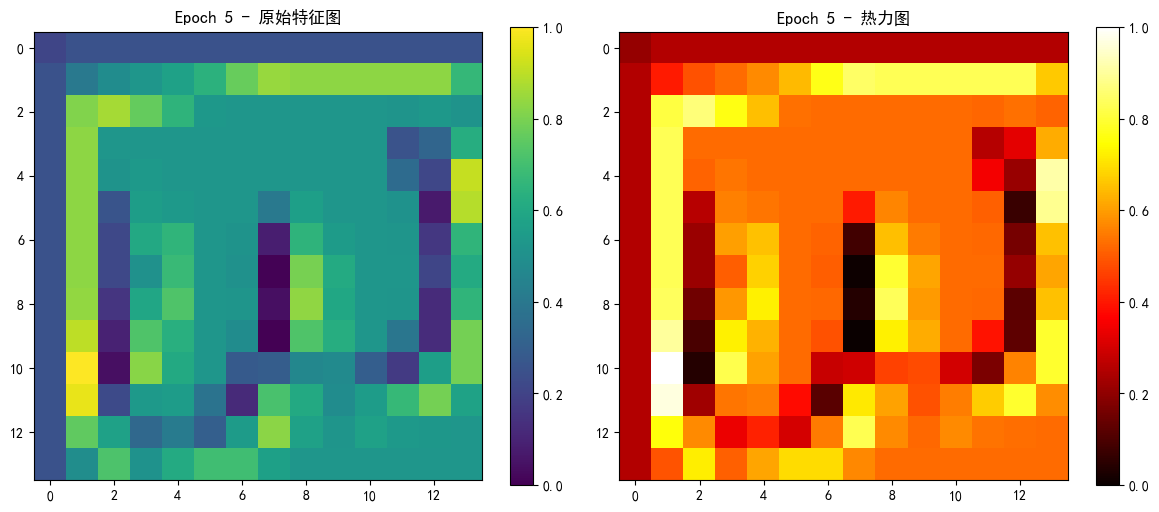

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_5.png
🎯 新最佳模型 (准确率: 0.5506) 已保存到 best_model_mobilenet_v2.pth
Epoch 6/500: Train Loss: 1.6233 | Val Loss: 1.4733 | Train Top-1: 0.5061 | Val Top-1: 0.5506 | Train Top-3: 0.7757 | Val Top-3: 0.8123
🎯 新最佳模型 (准确率: 0.6173) 已保存到 best_model_mobilenet_v2.pth
Epoch 7/500: Train Loss: 1.4063 | Val Loss: 1.2536 | Train Top-1: 0.5670 | Val Top-1: 0.6173 | Train Top-3: 0.8242 | Val Top-3: 0.8557
🎯 新最佳模型 (准确率: 0.6514) 已保存到 best_model_mobilenet_v2.pth
Epoch 8/500: Train Loss: 1.2351 | Val Loss: 1.1285 | Train Top-1: 0.6174 | Val Top-1: 0.6514 | Train Top-3: 0.8590 | Val Top-3: 0.8723
🎯 新最佳模型 (准确率: 0.6831) 已保存到 best_model_mobilenet_v2.pth
Epoch 9/500: Train Loss: 1.0902 | Val Loss: 1.0121 | Train Top-1: 0.6576 | Val Top-1: 0.6831 | Train Top-3: 0.8859 | Val Top-3: 0.8951
🎯 新最佳模型 (准确率: 0.7135) 已保存到 best_model_mobilenet_v2.pth
Epoch 10/500: Train Loss: 0.9847 | Val Loss: 0.9015 | Train Top-1: 0.6893 | Val Top-1: 0.7135 | Train Top-3: 0.9013 | Val Top-3:

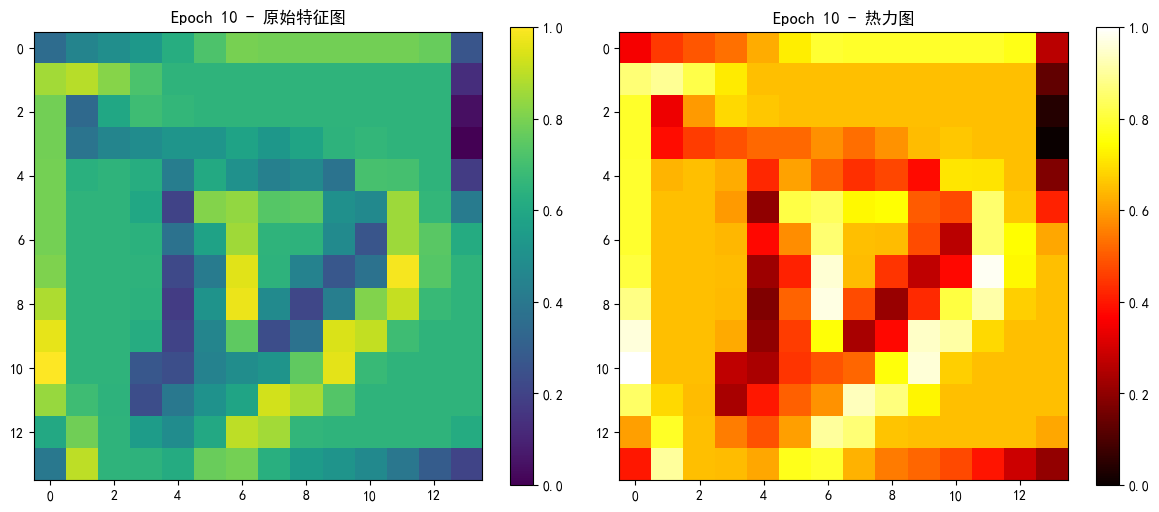

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_10.png
🎯 新最佳模型 (准确率: 0.7384) 已保存到 best_model_mobilenet_v2.pth
Epoch 11/500: Train Loss: 0.9044 | Val Loss: 0.8324 | Train Top-1: 0.7137 | Val Top-1: 0.7384 | Train Top-3: 0.9136 | Val Top-3: 0.9213
🎯 新最佳模型 (准确率: 0.7499) 已保存到 best_model_mobilenet_v2.pth
Epoch 12/500: Train Loss: 0.8275 | Val Loss: 0.7844 | Train Top-1: 0.7376 | Val Top-1: 0.7499 | Train Top-3: 0.9261 | Val Top-3: 0.9314
🎯 新最佳模型 (准确率: 0.7577) 已保存到 best_model_mobilenet_v2.pth
Epoch 13/500: Train Loss: 0.7638 | Val Loss: 0.7561 | Train Top-1: 0.7577 | Val Top-1: 0.7577 | Train Top-3: 0.9346 | Val Top-3: 0.9341
🎯 新最佳模型 (准确率: 0.7816) 已保存到 best_model_mobilenet_v2.pth
Epoch 14/500: Train Loss: 0.7154 | Val Loss: 0.7000 | Train Top-1: 0.7729 | Val Top-1: 0.7816 | Train Top-3: 0.9405 | Val Top-3: 0.9441
🎯 新最佳模型 (准确率: 0.7841) 已保存到 best_model_mobilenet_v2.pth
Epoch 15/500: Train Loss: 0.6650 | Val Loss: 0.6677 | Train Top-1: 0.7859 | Val Top-1: 0.7841 | Train Top-3: 0.9470 | Val T

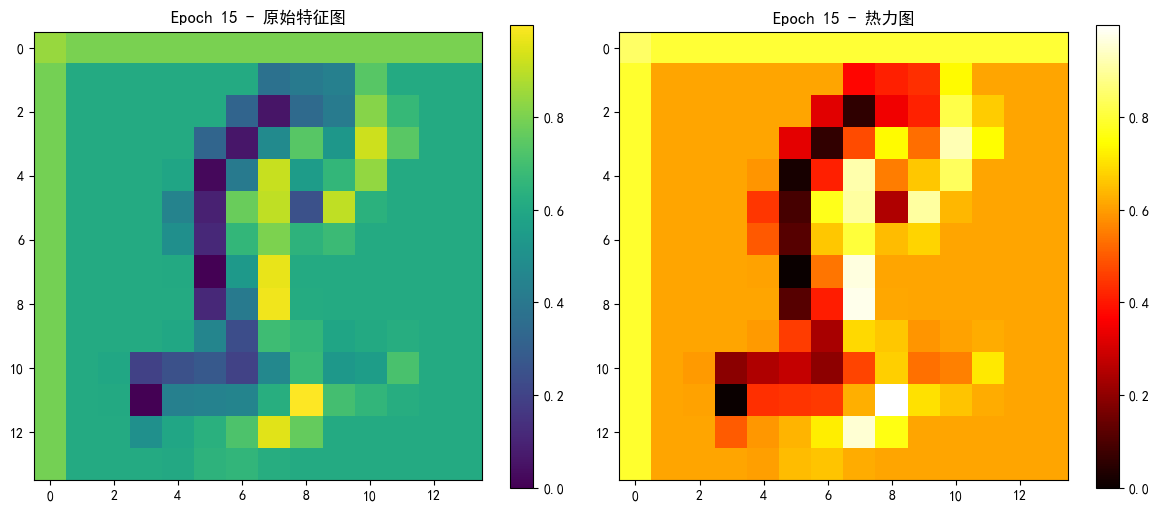

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_15.png
🎯 新最佳模型 (准确率: 0.7928) 已保存到 best_model_mobilenet_v2.pth
Epoch 16/500: Train Loss: 0.6358 | Val Loss: 0.6480 | Train Top-1: 0.7932 | Val Top-1: 0.7928 | Train Top-3: 0.9513 | Val Top-3: 0.9495
🎯 新最佳模型 (准确率: 0.7991) 已保存到 best_model_mobilenet_v2.pth
Epoch 17/500: Train Loss: 0.5883 | Val Loss: 0.6024 | Train Top-1: 0.8105 | Val Top-1: 0.7991 | Train Top-3: 0.9580 | Val Top-3: 0.9524
🎯 新最佳模型 (准确率: 0.8018) 已保存到 best_model_mobilenet_v2.pth
Epoch 18/500: Train Loss: 0.5630 | Val Loss: 0.5907 | Train Top-1: 0.8164 | Val Top-1: 0.8018 | Train Top-3: 0.9595 | Val Top-3: 0.9571
🎯 新最佳模型 (准确率: 0.8177) 已保存到 best_model_mobilenet_v2.pth
Epoch 19/500: Train Loss: 0.5378 | Val Loss: 0.5583 | Train Top-1: 0.8244 | Val Top-1: 0.8177 | Train Top-3: 0.9631 | Val Top-3: 0.9591
Epoch 20/500: Train Loss: 0.5188 | Val Loss: 0.5523 | Train Top-1: 0.8296 | Val Top-1: 0.8177 | Train Top-3: 0.9658 | Val Top-3: 0.9578


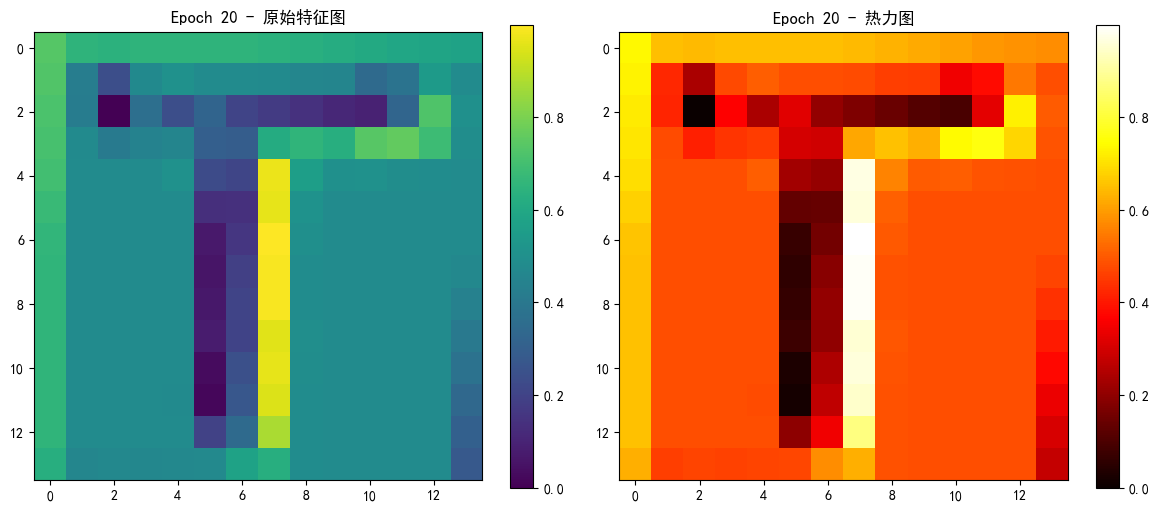

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_20.png
🎯 新最佳模型 (准确率: 0.8207) 已保存到 best_model_mobilenet_v2.pth
Epoch 21/500: Train Loss: 0.4951 | Val Loss: 0.5648 | Train Top-1: 0.8377 | Val Top-1: 0.8207 | Train Top-3: 0.9673 | Val Top-3: 0.9569
🎯 新最佳模型 (准确率: 0.8301) 已保存到 best_model_mobilenet_v2.pth
Epoch 22/500: Train Loss: 0.4749 | Val Loss: 0.5202 | Train Top-1: 0.8434 | Val Top-1: 0.8301 | Train Top-3: 0.9692 | Val Top-3: 0.9623
🎯 新最佳模型 (准确率: 0.8436) 已保存到 best_model_mobilenet_v2.pth
Epoch 23/500: Train Loss: 0.4571 | Val Loss: 0.4859 | Train Top-1: 0.8479 | Val Top-1: 0.8436 | Train Top-3: 0.9736 | Val Top-3: 0.9679
Epoch 24/500: Train Loss: 0.4330 | Val Loss: 0.4941 | Train Top-1: 0.8560 | Val Top-1: 0.8418 | Train Top-3: 0.9741 | Val Top-3: 0.9681
Epoch 25/500: Train Loss: 0.4282 | Val Loss: 0.5017 | Train Top-1: 0.8588 | Val Top-1: 0.8425 | Train Top-3: 0.9756 | Val Top-3: 0.9649


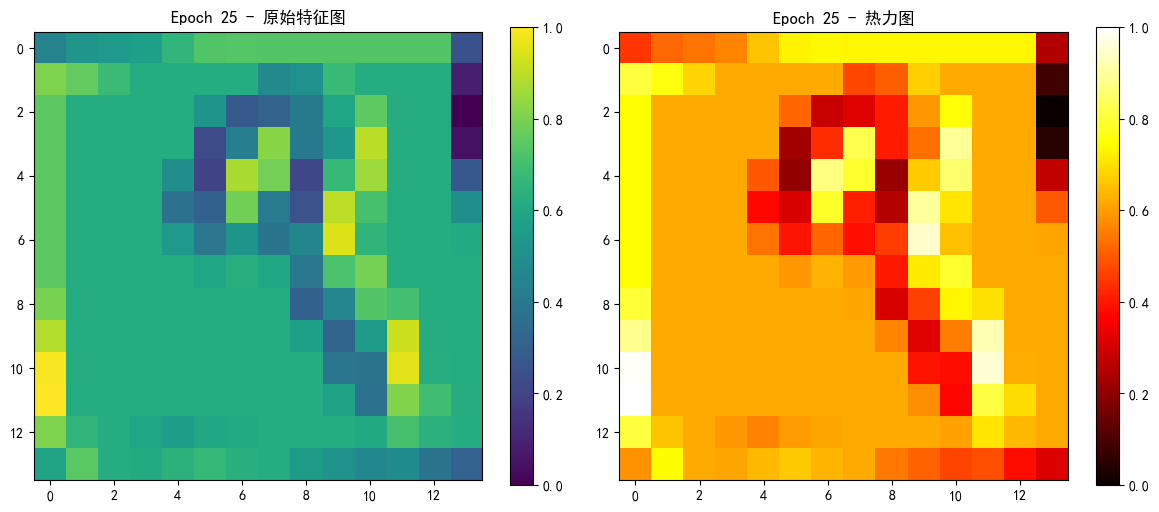

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_25.png
Epoch 26/500: Train Loss: 0.4057 | Val Loss: 0.4846 | Train Top-1: 0.8637 | Val Top-1: 0.8436 | Train Top-3: 0.9785 | Val Top-3: 0.9692
🎯 新最佳模型 (准确率: 0.8479) 已保存到 best_model_mobilenet_v2.pth
Epoch 27/500: Train Loss: 0.3997 | Val Loss: 0.4653 | Train Top-1: 0.8650 | Val Top-1: 0.8479 | Train Top-3: 0.9789 | Val Top-3: 0.9679
🎯 新最佳模型 (准确率: 0.8485) 已保存到 best_model_mobilenet_v2.pth
Epoch 28/500: Train Loss: 0.3903 | Val Loss: 0.4696 | Train Top-1: 0.8669 | Val Top-1: 0.8485 | Train Top-3: 0.9796 | Val Top-3: 0.9699
🎯 新最佳模型 (准确率: 0.8517) 已保存到 best_model_mobilenet_v2.pth
Epoch 29/500: Train Loss: 0.3731 | Val Loss: 0.4612 | Train Top-1: 0.8744 | Val Top-1: 0.8517 | Train Top-3: 0.9800 | Val Top-3: 0.9708
Epoch 30/500: Train Loss: 0.3617 | Val Loss: 0.4548 | Train Top-1: 0.8792 | Val Top-1: 0.8497 | Train Top-3: 0.9806 | Val Top-3: 0.9723


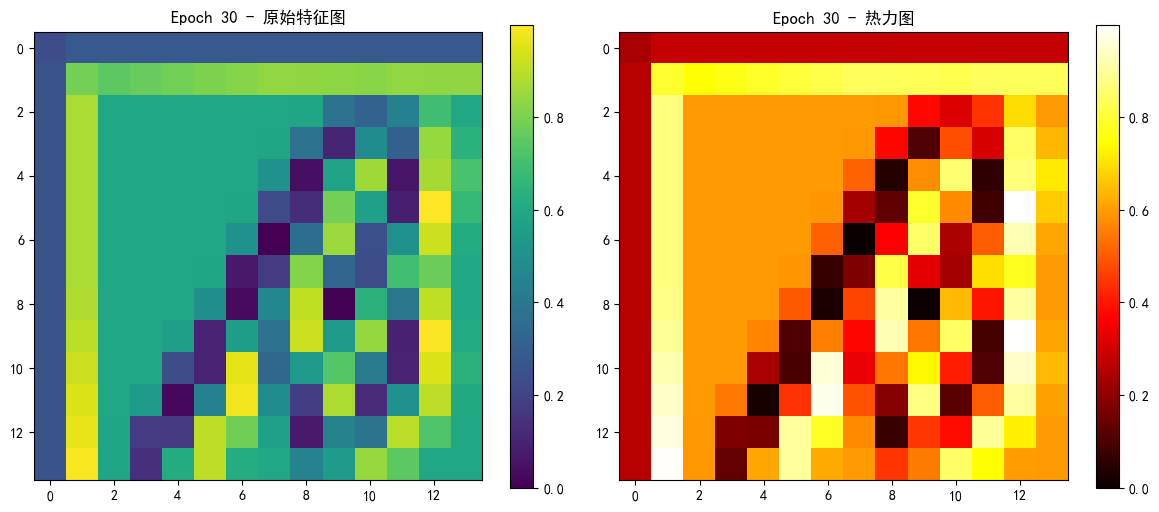

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_30.png
🎯 新最佳模型 (准确率: 0.8550) 已保存到 best_model_mobilenet_v2.pth
Epoch 31/500: Train Loss: 0.3522 | Val Loss: 0.4502 | Train Top-1: 0.8775 | Val Top-1: 0.8550 | Train Top-3: 0.9831 | Val Top-3: 0.9710
Epoch 32/500: Train Loss: 0.3444 | Val Loss: 0.4670 | Train Top-1: 0.8827 | Val Top-1: 0.8499 | Train Top-3: 0.9836 | Val Top-3: 0.9681
🎯 新最佳模型 (准确率: 0.8625) 已保存到 best_model_mobilenet_v2.pth
Epoch 33/500: Train Loss: 0.3347 | Val Loss: 0.4326 | Train Top-1: 0.8868 | Val Top-1: 0.8625 | Train Top-3: 0.9840 | Val Top-3: 0.9728
Epoch 34/500: Train Loss: 0.3245 | Val Loss: 0.4322 | Train Top-1: 0.8902 | Val Top-1: 0.8611 | Train Top-3: 0.9847 | Val Top-3: 0.9733
Epoch 35/500: Train Loss: 0.3184 | Val Loss: 0.4403 | Train Top-1: 0.8898 | Val Top-1: 0.8595 | Train Top-3: 0.9859 | Val Top-3: 0.9739


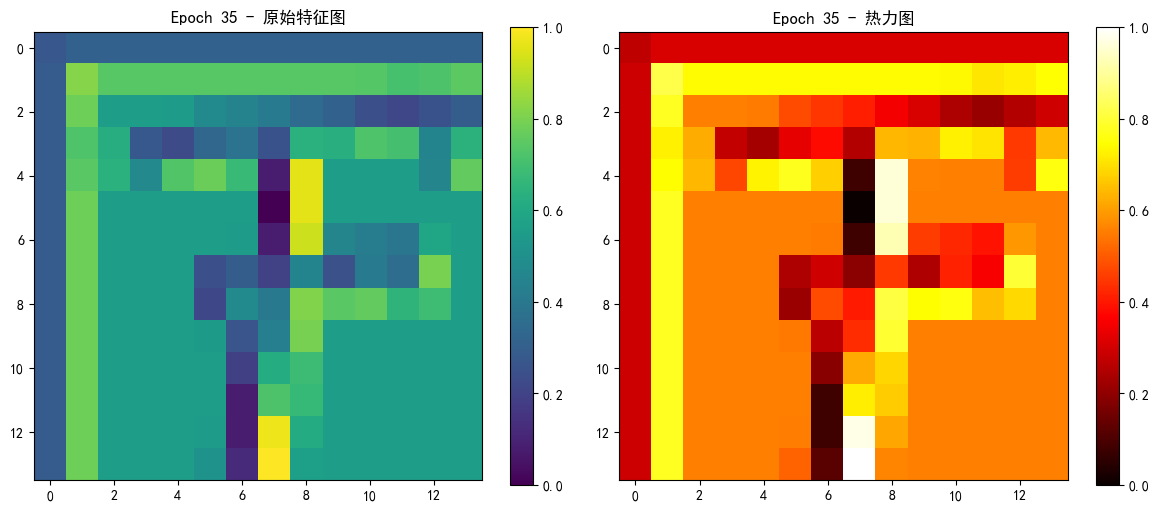

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_35.png
🎯 新最佳模型 (准确率: 0.8629) 已保存到 best_model_mobilenet_v2.pth
Epoch 36/500: Train Loss: 0.3046 | Val Loss: 0.4194 | Train Top-1: 0.8941 | Val Top-1: 0.8629 | Train Top-3: 0.9876 | Val Top-3: 0.9714
Epoch 37/500: Train Loss: 0.2992 | Val Loss: 0.4374 | Train Top-1: 0.8947 | Val Top-1: 0.8586 | Train Top-3: 0.9886 | Val Top-3: 0.9728
🎯 新最佳模型 (准确率: 0.8640) 已保存到 best_model_mobilenet_v2.pth
Epoch 38/500: Train Loss: 0.3023 | Val Loss: 0.4246 | Train Top-1: 0.8942 | Val Top-1: 0.8640 | Train Top-3: 0.9873 | Val Top-3: 0.9732
Epoch 39/500: Train Loss: 0.2882 | Val Loss: 0.4229 | Train Top-1: 0.8995 | Val Top-1: 0.8593 | Train Top-3: 0.9885 | Val Top-3: 0.9762
Epoch 40/500: Train Loss: 0.2894 | Val Loss: 0.4145 | Train Top-1: 0.8998 | Val Top-1: 0.8614 | Train Top-3: 0.9885 | Val Top-3: 0.9748


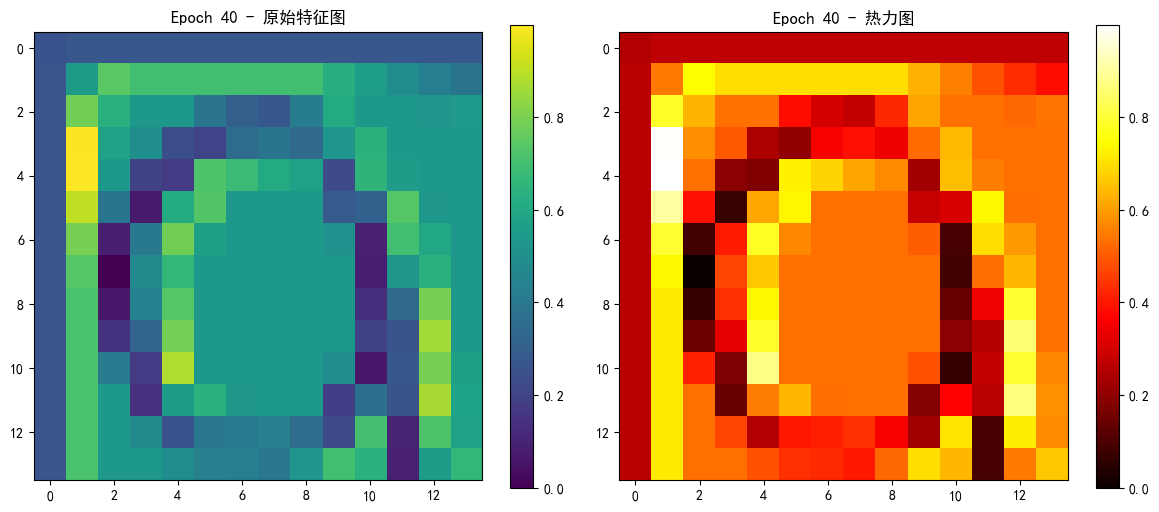

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_40.png
Epoch 41/500: Train Loss: 0.2806 | Val Loss: 0.4087 | Train Top-1: 0.9029 | Val Top-1: 0.8638 | Train Top-3: 0.9895 | Val Top-3: 0.9769
🎯 新最佳模型 (准确率: 0.8724) 已保存到 best_model_mobilenet_v2.pth
Epoch 42/500: Train Loss: 0.2722 | Val Loss: 0.4038 | Train Top-1: 0.9032 | Val Top-1: 0.8724 | Train Top-3: 0.9907 | Val Top-3: 0.9735
Epoch 43/500: Train Loss: 0.2651 | Val Loss: 0.4092 | Train Top-1: 0.9061 | Val Top-1: 0.8656 | Train Top-3: 0.9910 | Val Top-3: 0.9789
Epoch 44/500: Train Loss: 0.2585 | Val Loss: 0.4088 | Train Top-1: 0.9093 | Val Top-1: 0.8652 | Train Top-3: 0.9907 | Val Top-3: 0.9784
🎯 新最佳模型 (准确率: 0.8739) 已保存到 best_model_mobilenet_v2.pth
Epoch 45/500: Train Loss: 0.2538 | Val Loss: 0.3946 | Train Top-1: 0.9096 | Val Top-1: 0.8739 | Train Top-3: 0.9910 | Val Top-3: 0.9773


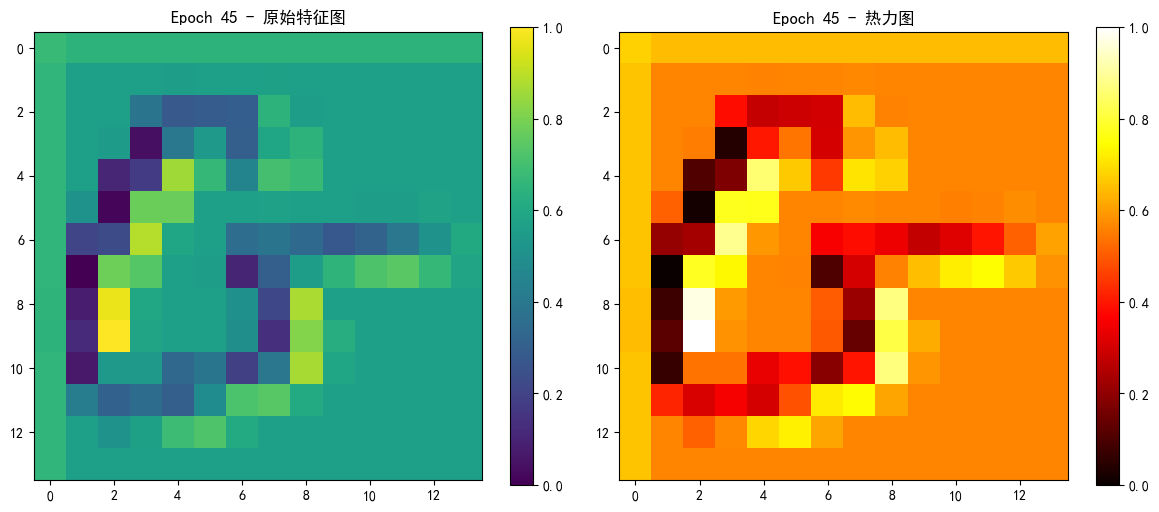

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_45.png
Epoch 46/500: Train Loss: 0.2522 | Val Loss: 0.4064 | Train Top-1: 0.9109 | Val Top-1: 0.8692 | Train Top-3: 0.9915 | Val Top-3: 0.9760
Epoch 47/500: Train Loss: 0.2434 | Val Loss: 0.4184 | Train Top-1: 0.9144 | Val Top-1: 0.8719 | Train Top-3: 0.9923 | Val Top-3: 0.9753
Epoch 48/500: Train Loss: 0.2410 | Val Loss: 0.3998 | Train Top-1: 0.9126 | Val Top-1: 0.8694 | Train Top-3: 0.9925 | Val Top-3: 0.9777
Epoch 49/500: Train Loss: 0.2369 | Val Loss: 0.4077 | Train Top-1: 0.9138 | Val Top-1: 0.8712 | Train Top-3: 0.9924 | Val Top-3: 0.9759
🎯 新最佳模型 (准确率: 0.8780) 已保存到 best_model_mobilenet_v2.pth
Epoch 50/500: Train Loss: 0.2329 | Val Loss: 0.3995 | Train Top-1: 0.9172 | Val Top-1: 0.8780 | Train Top-3: 0.9931 | Val Top-3: 0.9778


E:\计算智能\myCnn\cnnWithAttention\train_my_cnn.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))


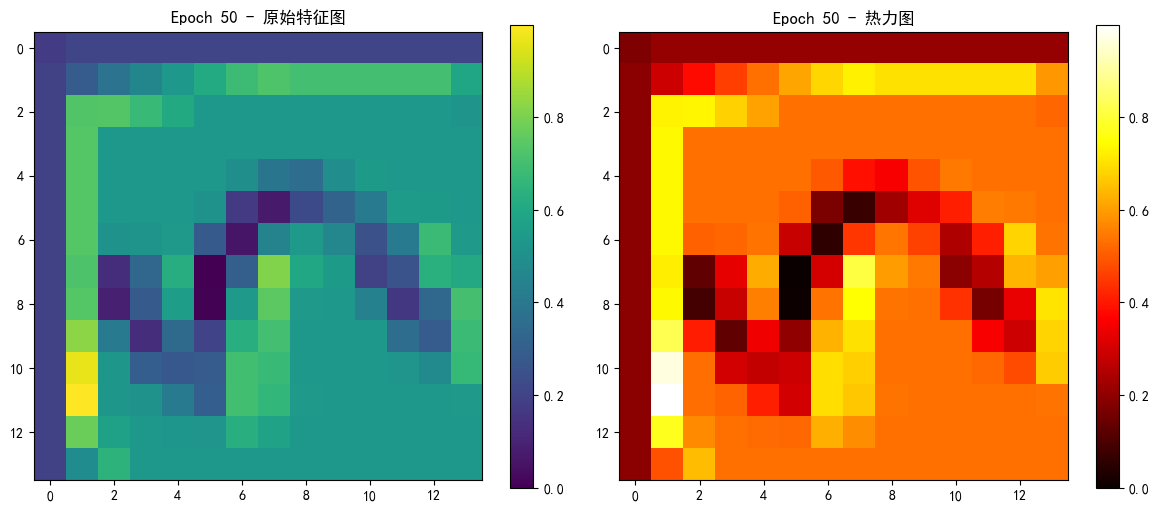

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_50.png
Epoch 51/500: Train Loss: 0.2231 | Val Loss: 0.3905 | Train Top-1: 0.9193 | Val Top-1: 0.8746 | Train Top-3: 0.9939 | Val Top-3: 0.9771
Epoch 52/500: Train Loss: 0.2208 | Val Loss: 0.3942 | Train Top-1: 0.9201 | Val Top-1: 0.8760 | Train Top-3: 0.9940 | Val Top-3: 0.9782
Epoch 53/500: Train Loss: 0.2176 | Val Loss: 0.3793 | Train Top-1: 0.9216 | Val Top-1: 0.8773 | Train Top-3: 0.9939 | Val Top-3: 0.9809
🎯 新最佳模型 (准确率: 0.8787) 已保存到 best_model_mobilenet_v2.pth
Epoch 54/500: Train Loss: 0.2130 | Val Loss: 0.3905 | Train Top-1: 0.9225 | Val Top-1: 0.8787 | Train Top-3: 0.9947 | Val Top-3: 0.9777
🎯 新最佳模型 (准确率: 0.8807) 已保存到 best_model_mobilenet_v2.pth
Epoch 55/500: Train Loss: 0.2069 | Val Loss: 0.4020 | Train Top-1: 0.9236 | Val Top-1: 0.8807 | Train Top-3: 0.9956 | Val Top-3: 0.9773


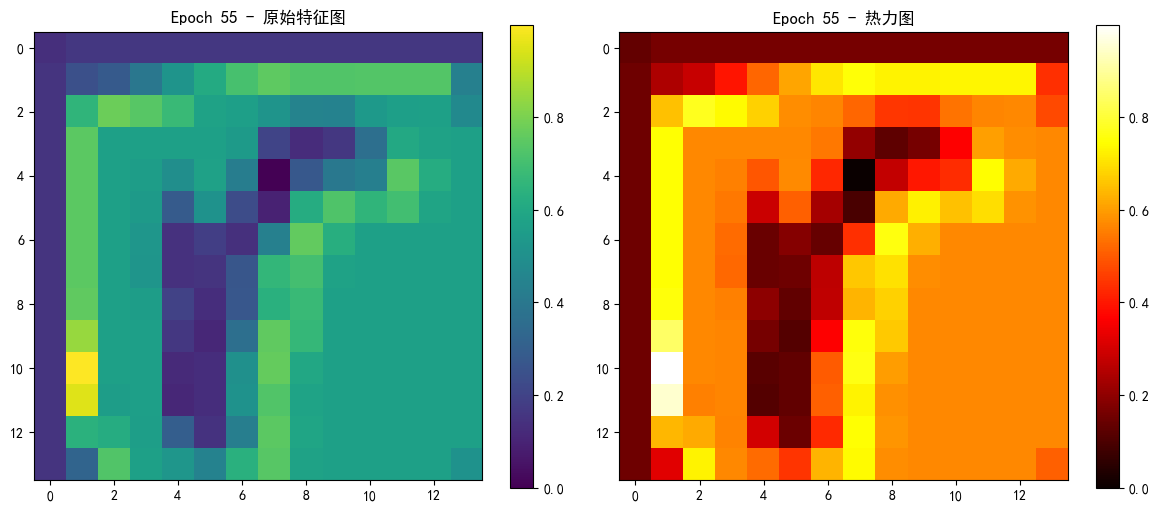

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_55.png
Epoch 56/500: Train Loss: 0.2060 | Val Loss: 0.3900 | Train Top-1: 0.9238 | Val Top-1: 0.8762 | Train Top-3: 0.9951 | Val Top-3: 0.9800
Epoch 57/500: Train Loss: 0.2014 | Val Loss: 0.3886 | Train Top-1: 0.9256 | Val Top-1: 0.8802 | Train Top-3: 0.9956 | Val Top-3: 0.9798
🎯 新最佳模型 (准确率: 0.8836) 已保存到 best_model_mobilenet_v2.pth
Epoch 58/500: Train Loss: 0.1956 | Val Loss: 0.3835 | Train Top-1: 0.9284 | Val Top-1: 0.8836 | Train Top-3: 0.9959 | Val Top-3: 0.9787
Epoch 59/500: Train Loss: 0.1967 | Val Loss: 0.4090 | Train Top-1: 0.9277 | Val Top-1: 0.8715 | Train Top-3: 0.9956 | Val Top-3: 0.9778
🎯 新最佳模型 (准确率: 0.8838) 已保存到 best_model_mobilenet_v2.pth
Epoch 60/500: Train Loss: 0.2028 | Val Loss: 0.3945 | Train Top-1: 0.9252 | Val Top-1: 0.8838 | Train Top-3: 0.9950 | Val Top-3: 0.9778


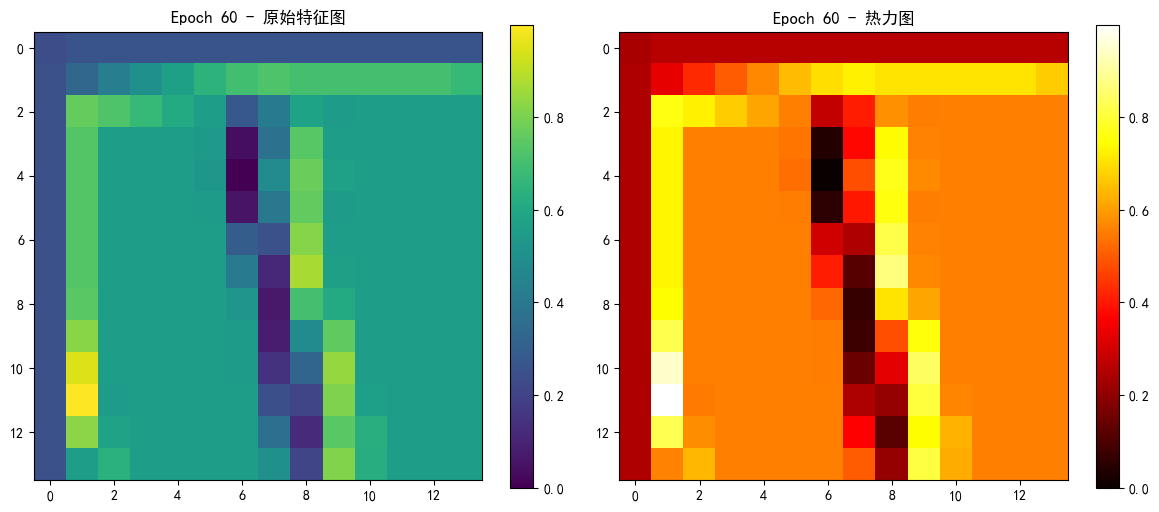

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_60.png
Epoch 61/500: Train Loss: 0.1943 | Val Loss: 0.3861 | Train Top-1: 0.9294 | Val Top-1: 0.8802 | Train Top-3: 0.9962 | Val Top-3: 0.9771
Epoch 62/500: Train Loss: 0.1943 | Val Loss: 0.3915 | Train Top-1: 0.9280 | Val Top-1: 0.8836 | Train Top-3: 0.9961 | Val Top-3: 0.9789
🎯 新最佳模型 (准确率: 0.8847) 已保存到 best_model_mobilenet_v2.pth
Epoch 63/500: Train Loss: 0.1897 | Val Loss: 0.3794 | Train Top-1: 0.9302 | Val Top-1: 0.8847 | Train Top-3: 0.9961 | Val Top-3: 0.9782
🎯 新最佳模型 (准确率: 0.8876) 已保存到 best_model_mobilenet_v2.pth
Epoch 64/500: Train Loss: 0.1831 | Val Loss: 0.3730 | Train Top-1: 0.9320 | Val Top-1: 0.8876 | Train Top-3: 0.9957 | Val Top-3: 0.9807
Epoch 65/500: Train Loss: 0.1815 | Val Loss: 0.3837 | Train Top-1: 0.9340 | Val Top-1: 0.8813 | Train Top-3: 0.9963 | Val Top-3: 0.9818


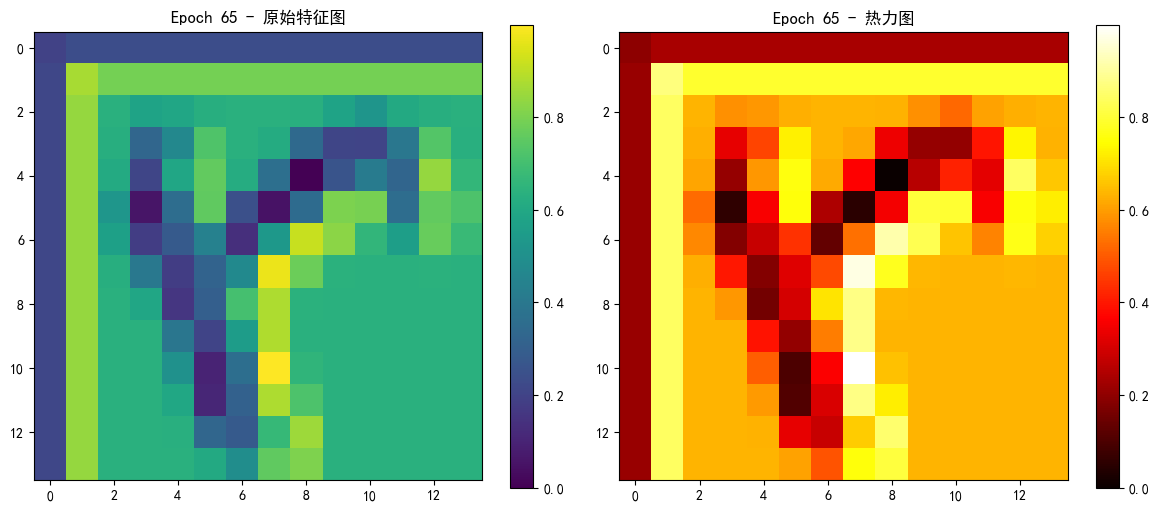

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_65.png
Epoch 66/500: Train Loss: 0.1823 | Val Loss: 0.3860 | Train Top-1: 0.9328 | Val Top-1: 0.8849 | Train Top-3: 0.9966 | Val Top-3: 0.9798
Epoch 67/500: Train Loss: 0.1717 | Val Loss: 0.3836 | Train Top-1: 0.9354 | Val Top-1: 0.8825 | Train Top-3: 0.9970 | Val Top-3: 0.9807
Epoch 68/500: Train Loss: 0.1721 | Val Loss: 0.3921 | Train Top-1: 0.9360 | Val Top-1: 0.8845 | Train Top-3: 0.9970 | Val Top-3: 0.9804
Epoch 69/500: Train Loss: 0.1746 | Val Loss: 0.3944 | Train Top-1: 0.9354 | Val Top-1: 0.8816 | Train Top-3: 0.9969 | Val Top-3: 0.9804
Epoch 70/500: Train Loss: 0.1685 | Val Loss: 0.3833 | Train Top-1: 0.9353 | Val Top-1: 0.8831 | Train Top-3: 0.9968 | Val Top-3: 0.9802


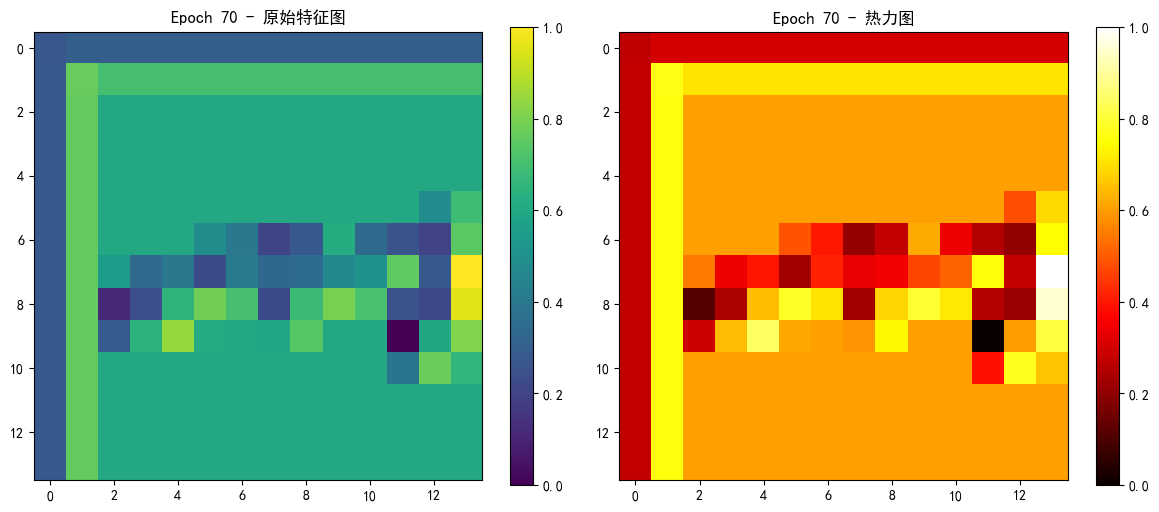

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_70.png
🎯 新最佳模型 (准确率: 0.8883) 已保存到 best_model_mobilenet_v2.pth
Epoch 71/500: Train Loss: 0.1671 | Val Loss: 0.3707 | Train Top-1: 0.9388 | Val Top-1: 0.8883 | Train Top-3: 0.9973 | Val Top-3: 0.9800
Epoch 72/500: Train Loss: 0.1645 | Val Loss: 0.3964 | Train Top-1: 0.9388 | Val Top-1: 0.8849 | Train Top-3: 0.9972 | Val Top-3: 0.9782
Epoch 73/500: Train Loss: 0.1643 | Val Loss: 0.3789 | Train Top-1: 0.9401 | Val Top-1: 0.8859 | Train Top-3: 0.9974 | Val Top-3: 0.9811
🎯 新最佳模型 (准确率: 0.8890) 已保存到 best_model_mobilenet_v2.pth
Epoch 74/500: Train Loss: 0.1575 | Val Loss: 0.3802 | Train Top-1: 0.9385 | Val Top-1: 0.8890 | Train Top-3: 0.9976 | Val Top-3: 0.9820
Epoch 75/500: Train Loss: 0.1558 | Val Loss: 0.3955 | Train Top-1: 0.9413 | Val Top-1: 0.8843 | Train Top-3: 0.9981 | Val Top-3: 0.9796


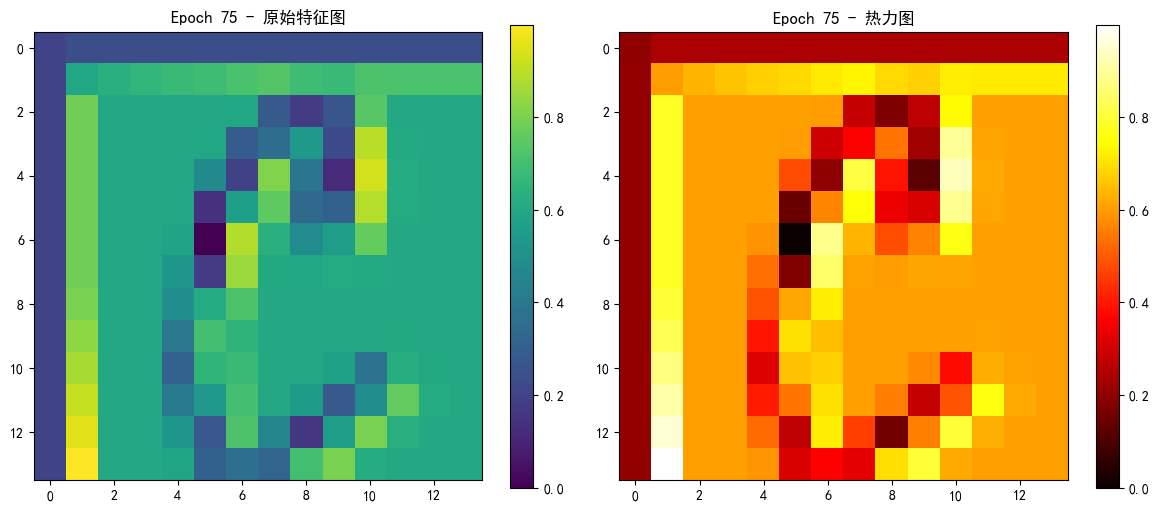

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_75.png
Epoch 76/500: Train Loss: 0.1633 | Val Loss: 0.3969 | Train Top-1: 0.9394 | Val Top-1: 0.8858 | Train Top-3: 0.9975 | Val Top-3: 0.9787
Epoch 77/500: Train Loss: 0.1549 | Val Loss: 0.3915 | Train Top-1: 0.9428 | Val Top-1: 0.8874 | Train Top-3: 0.9978 | Val Top-3: 0.9807
Epoch 78/500: Train Loss: 0.1546 | Val Loss: 0.3938 | Train Top-1: 0.9409 | Val Top-1: 0.8838 | Train Top-3: 0.9977 | Val Top-3: 0.9805
Epoch 79/500: Train Loss: 0.1518 | Val Loss: 0.3927 | Train Top-1: 0.9418 | Val Top-1: 0.8849 | Train Top-3: 0.9984 | Val Top-3: 0.9811
🎯 新最佳模型 (准确率: 0.8895) 已保存到 best_model_mobilenet_v2.pth
Epoch 80/500: Train Loss: 0.1510 | Val Loss: 0.3691 | Train Top-1: 0.9430 | Val Top-1: 0.8895 | Train Top-3: 0.9981 | Val Top-3: 0.9832


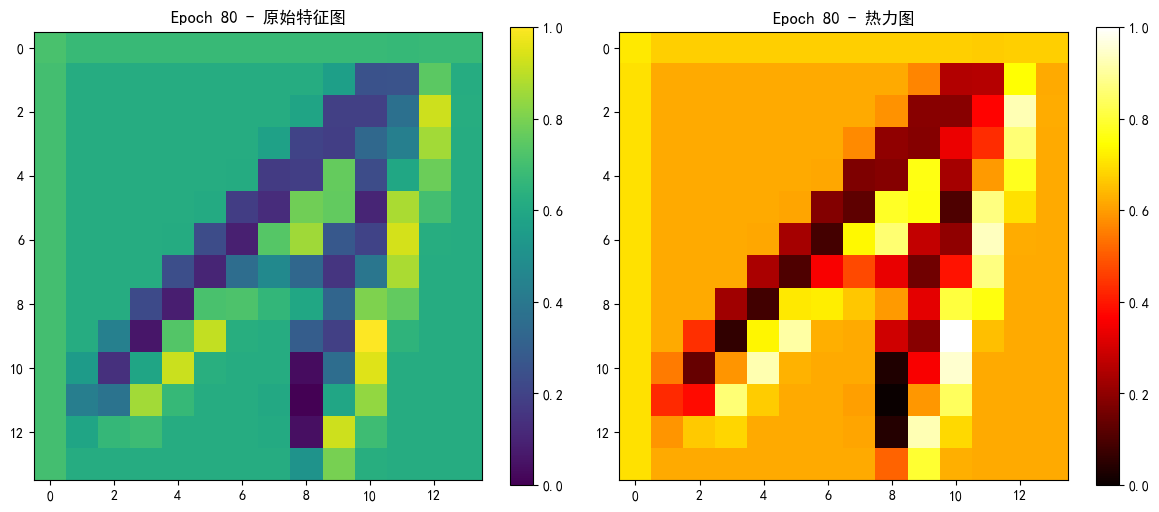

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_80.png
🎯 新最佳模型 (准确率: 0.8903) 已保存到 best_model_mobilenet_v2.pth
Epoch 81/500: Train Loss: 0.1472 | Val Loss: 0.3743 | Train Top-1: 0.9431 | Val Top-1: 0.8903 | Train Top-3: 0.9980 | Val Top-3: 0.9827
Epoch 82/500: Train Loss: 0.1460 | Val Loss: 0.4024 | Train Top-1: 0.9455 | Val Top-1: 0.8841 | Train Top-3: 0.9979 | Val Top-3: 0.9787
Epoch 83/500: Train Loss: 0.1462 | Val Loss: 0.3963 | Train Top-1: 0.9453 | Val Top-1: 0.8850 | Train Top-3: 0.9980 | Val Top-3: 0.9795
Epoch 84/500: Train Loss: 0.1468 | Val Loss: 0.3753 | Train Top-1: 0.9444 | Val Top-1: 0.8861 | Train Top-3: 0.9979 | Val Top-3: 0.9836
Epoch 85/500: Train Loss: 0.1418 | Val Loss: 0.3940 | Train Top-1: 0.9461 | Val Top-1: 0.8879 | Train Top-3: 0.9980 | Val Top-3: 0.9811


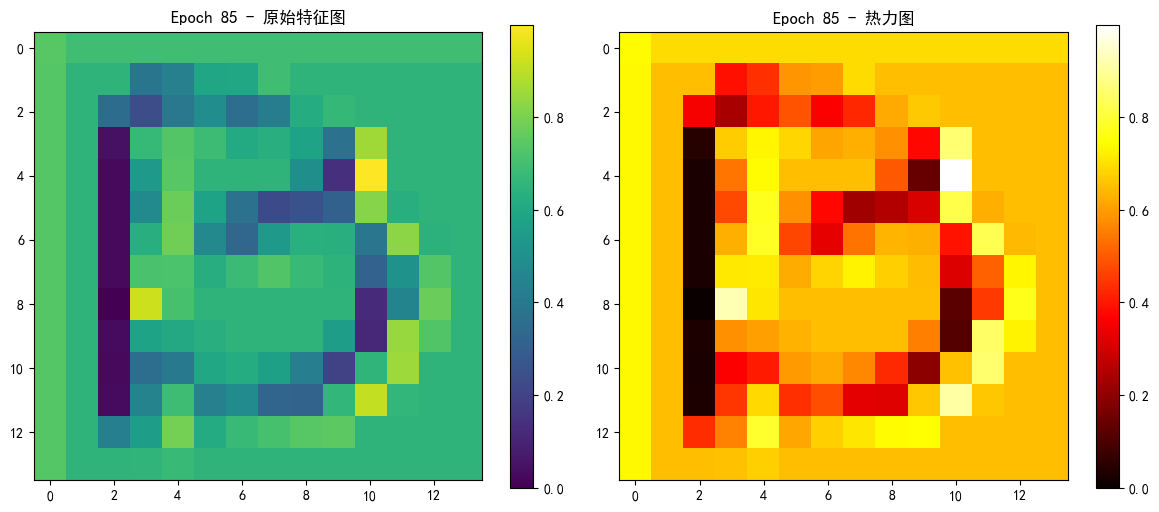

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_85.png
Epoch 86/500: Train Loss: 0.1393 | Val Loss: 0.3974 | Train Top-1: 0.9472 | Val Top-1: 0.8874 | Train Top-3: 0.9981 | Val Top-3: 0.9807
Epoch 87/500: Train Loss: 0.1372 | Val Loss: 0.3844 | Train Top-1: 0.9472 | Val Top-1: 0.8885 | Train Top-3: 0.9983 | Val Top-3: 0.9832
Epoch 88/500: Train Loss: 0.1353 | Val Loss: 0.3969 | Train Top-1: 0.9486 | Val Top-1: 0.8874 | Train Top-3: 0.9984 | Val Top-3: 0.9838
Epoch 89/500: Train Loss: 0.1343 | Val Loss: 0.4056 | Train Top-1: 0.9491 | Val Top-1: 0.8843 | Train Top-3: 0.9987 | Val Top-3: 0.9813
Epoch 90/500: Train Loss: 0.1361 | Val Loss: 0.4002 | Train Top-1: 0.9473 | Val Top-1: 0.8890 | Train Top-3: 0.9982 | Val Top-3: 0.9818


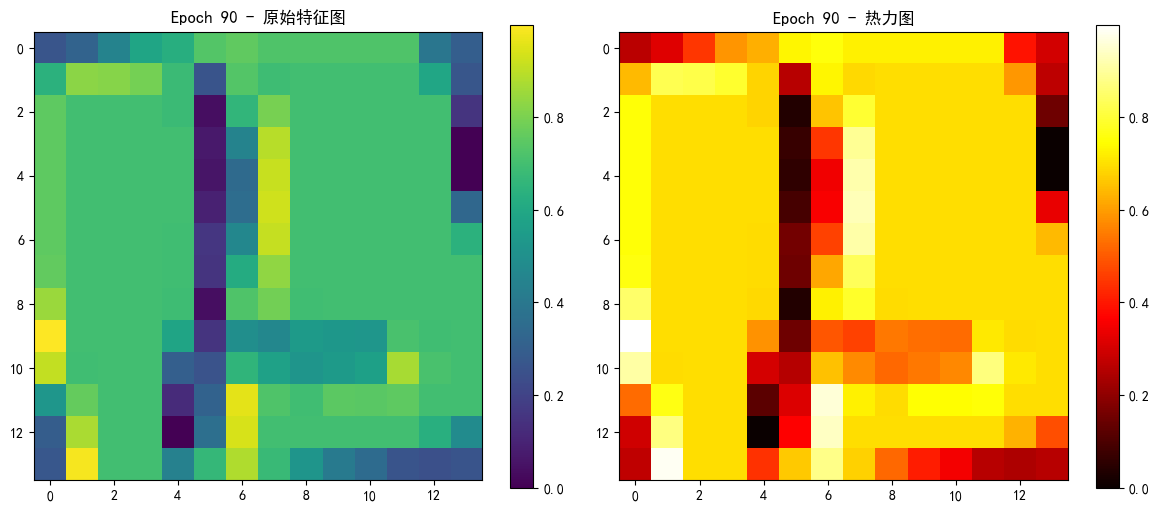

🖼️ 特征图已保存到: runs/20250424_162157\feature_map_epoch_90.png
⏹️ 早停触发: 验证准确率连续 10 轮未提升
✅ 特征图钩子已移除


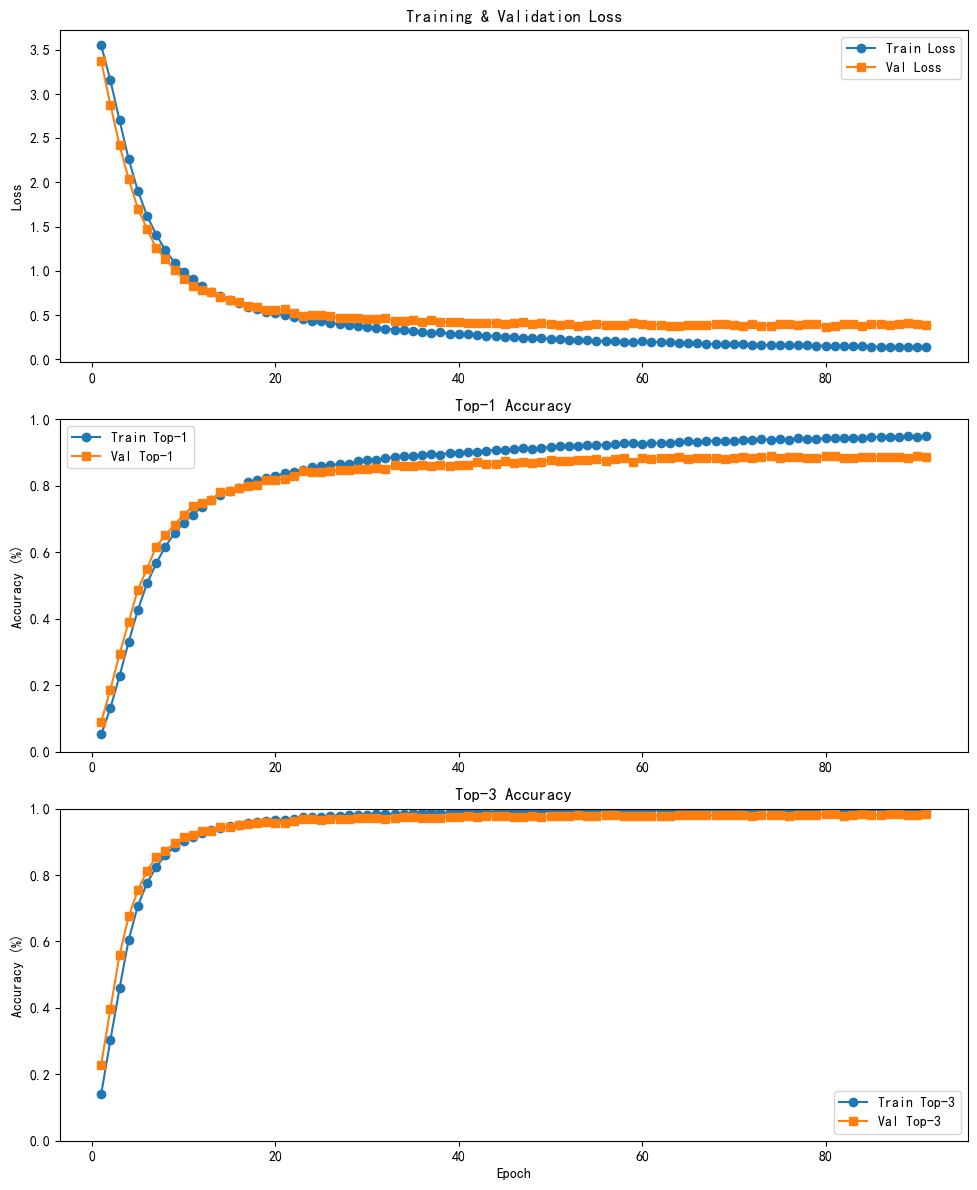

📊 训练图表已保存到: training_plots\training_metrics_20250424_164516.png


In [10]:
mobilenet_v2 = train_and_validate(model=mobilenet_v2,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_mobilenet_v2.pth",
    lr=LR)


🔍 特征图钩子已注册到: Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))


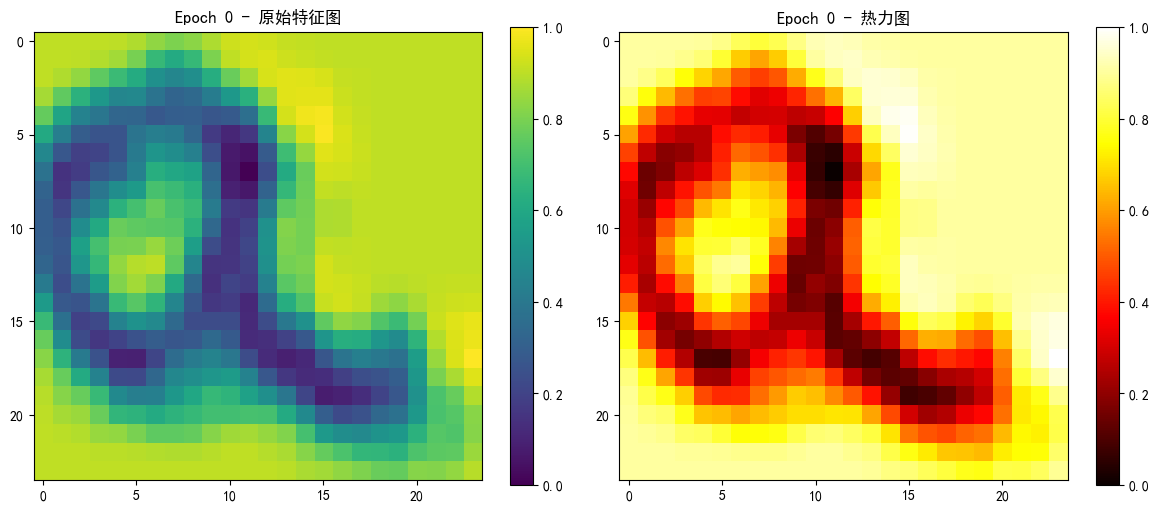

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_0.png
🎯 新最佳模型 (准确率: 0.2041) 已保存到 best_model_LeNet5.pth
Epoch 1/500: Train Loss: 3.4440 | Val Loss: 2.9162 | Train Top-1: 0.0818 | Val Top-1: 0.2041 | Train Top-3: 0.2014 | Val Top-3: 0.4568
🎯 新最佳模型 (准确率: 0.3982) 已保存到 best_model_LeNet5.pth
Epoch 2/500: Train Loss: 2.4275 | Val Loss: 2.1258 | Train Top-1: 0.3363 | Val Top-1: 0.3982 | Train Top-3: 0.5889 | Val Top-3: 0.6575
🎯 新最佳模型 (准确率: 0.4841) 已保存到 best_model_LeNet5.pth
Epoch 3/500: Train Loss: 1.9611 | Val Loss: 1.8355 | Train Top-1: 0.4558 | Val Top-1: 0.4841 | Train Top-3: 0.7033 | Val Top-3: 0.7346
🎯 新最佳模型 (准确率: 0.5274) 已保存到 best_model_LeNet5.pth
Epoch 4/500: Train Loss: 1.7448 | Val Loss: 1.6798 | Train Top-1: 0.5064 | Val Top-1: 0.5274 | Train Top-3: 0.7537 | Val Top-3: 0.7647
🎯 新最佳模型 (准确率: 0.5645) 已保存到 best_model_LeNet5.pth
Epoch 5/500: Train Loss: 1.5934 | Val Loss: 1.5147 | Train Top-1: 0.5461 | Val Top-1: 0.5645 | Train Top-3: 0.7844 | Val Top-3: 0.7996


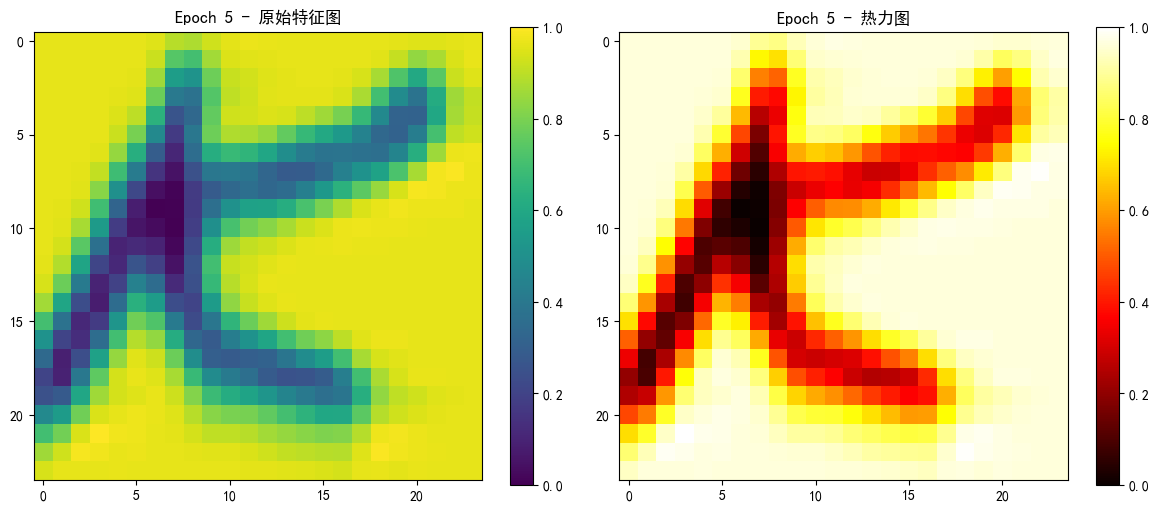

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_5.png
🎯 新最佳模型 (准确率: 0.6059) 已保存到 best_model_LeNet5.pth
Epoch 6/500: Train Loss: 1.4425 | Val Loss: 1.3763 | Train Top-1: 0.5854 | Val Top-1: 0.6059 | Train Top-3: 0.8187 | Val Top-3: 0.8281
🎯 新最佳模型 (准确率: 0.6350) 已保存到 best_model_LeNet5.pth
Epoch 7/500: Train Loss: 1.3315 | Val Loss: 1.2670 | Train Top-1: 0.6148 | Val Top-1: 0.6350 | Train Top-3: 0.8369 | Val Top-3: 0.8497
🎯 新最佳模型 (准确率: 0.6497) 已保存到 best_model_LeNet5.pth
Epoch 8/500: Train Loss: 1.2337 | Val Loss: 1.2069 | Train Top-1: 0.6397 | Val Top-1: 0.6497 | Train Top-3: 0.8571 | Val Top-3: 0.8596
🎯 新最佳模型 (准确率: 0.6741) 已保存到 best_model_LeNet5.pth
Epoch 9/500: Train Loss: 1.1592 | Val Loss: 1.1317 | Train Top-1: 0.6611 | Val Top-1: 0.6741 | Train Top-3: 0.8680 | Val Top-3: 0.8717
🎯 新最佳模型 (准确率: 0.6932) 已保存到 best_model_LeNet5.pth
Epoch 10/500: Train Loss: 1.0947 | Val Loss: 1.0644 | Train Top-1: 0.6791 | Val Top-1: 0.6932 | Train Top-3: 0.8810 | Val Top-3: 0.8843


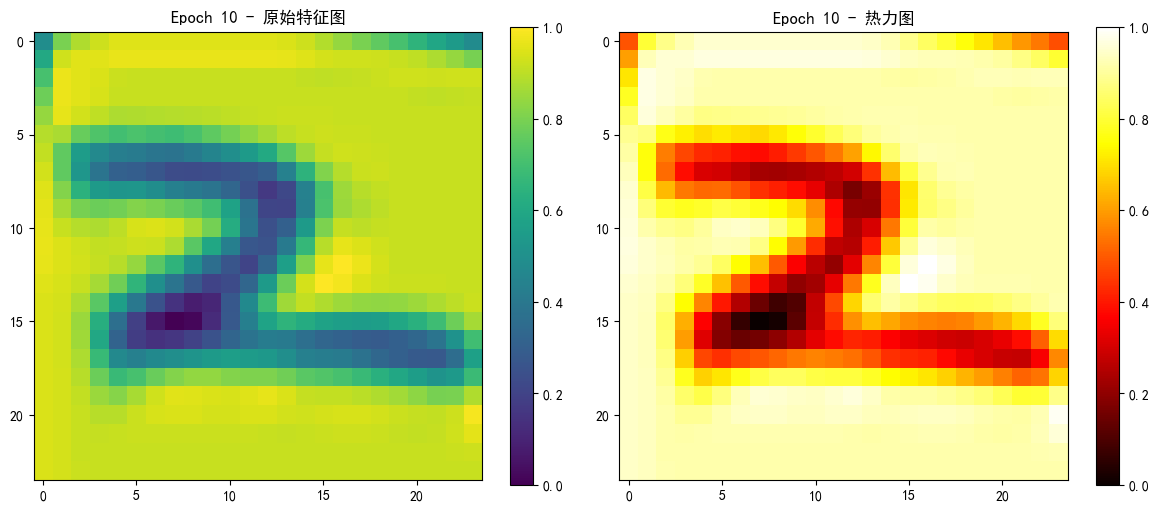

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_10.png
🎯 新最佳模型 (准确率: 0.7061) 已保存到 best_model_LeNet5.pth
Epoch 11/500: Train Loss: 1.0419 | Val Loss: 1.0126 | Train Top-1: 0.6968 | Val Top-1: 0.7061 | Train Top-3: 0.8903 | Val Top-3: 0.8966
🎯 新最佳模型 (准确率: 0.7094) 已保存到 best_model_LeNet5.pth
Epoch 12/500: Train Loss: 0.9860 | Val Loss: 0.9622 | Train Top-1: 0.7097 | Val Top-1: 0.7094 | Train Top-3: 0.8973 | Val Top-3: 0.9013
🎯 新最佳模型 (准确率: 0.7281) 已保存到 best_model_LeNet5.pth
Epoch 13/500: Train Loss: 0.9515 | Val Loss: 0.9386 | Train Top-1: 0.7257 | Val Top-1: 0.7281 | Train Top-3: 0.9041 | Val Top-3: 0.9027
🎯 新最佳模型 (准确率: 0.7297) 已保存到 best_model_LeNet5.pth
Epoch 14/500: Train Loss: 0.9069 | Val Loss: 0.9116 | Train Top-1: 0.7346 | Val Top-1: 0.7297 | Train Top-3: 0.9103 | Val Top-3: 0.9063
🎯 新最佳模型 (准确率: 0.7481) 已保存到 best_model_LeNet5.pth
Epoch 15/500: Train Loss: 0.8751 | Val Loss: 0.8465 | Train Top-1: 0.7448 | Val Top-1: 0.7481 | Train Top-3: 0.9142 | Val Top-3: 0.9151


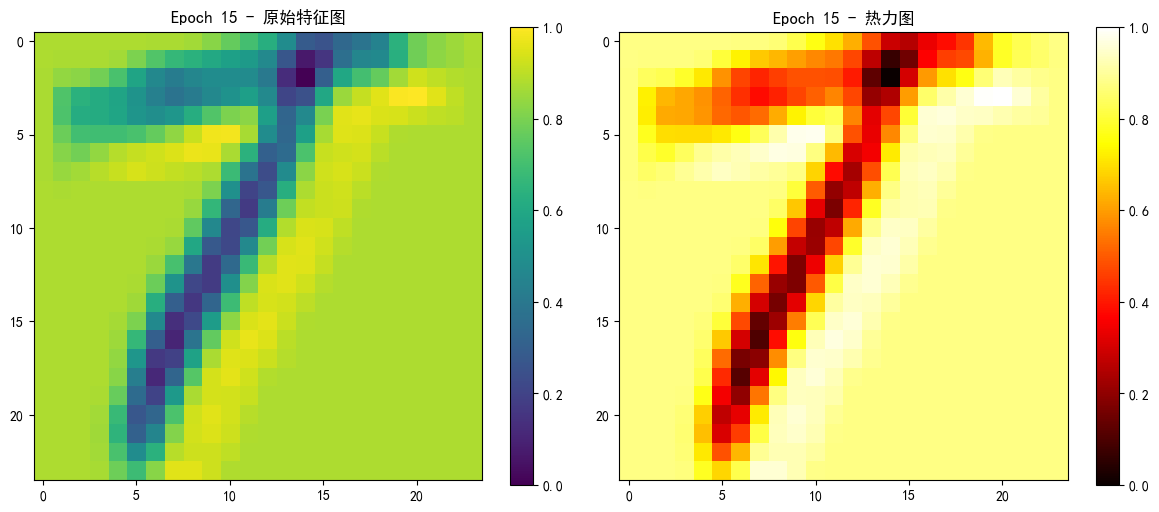

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_15.png
Epoch 16/500: Train Loss: 0.8538 | Val Loss: 0.8318 | Train Top-1: 0.7477 | Val Top-1: 0.7479 | Train Top-3: 0.9189 | Val Top-3: 0.9195
🎯 新最佳模型 (准确率: 0.7647) 已保存到 best_model_LeNet5.pth
Epoch 17/500: Train Loss: 0.8228 | Val Loss: 0.7926 | Train Top-1: 0.7578 | Val Top-1: 0.7647 | Train Top-3: 0.9219 | Val Top-3: 0.9272
Epoch 18/500: Train Loss: 0.7940 | Val Loss: 0.7972 | Train Top-1: 0.7665 | Val Top-1: 0.7593 | Train Top-3: 0.9263 | Val Top-3: 0.9258
🎯 新最佳模型 (准确率: 0.7703) 已保存到 best_model_LeNet5.pth
Epoch 19/500: Train Loss: 0.7766 | Val Loss: 0.7594 | Train Top-1: 0.7735 | Val Top-1: 0.7703 | Train Top-3: 0.9295 | Val Top-3: 0.9305
🎯 新最佳模型 (准确率: 0.7805) 已保存到 best_model_LeNet5.pth
Epoch 20/500: Train Loss: 0.7459 | Val Loss: 0.7390 | Train Top-1: 0.7792 | Val Top-1: 0.7805 | Train Top-3: 0.9333 | Val Top-3: 0.9337


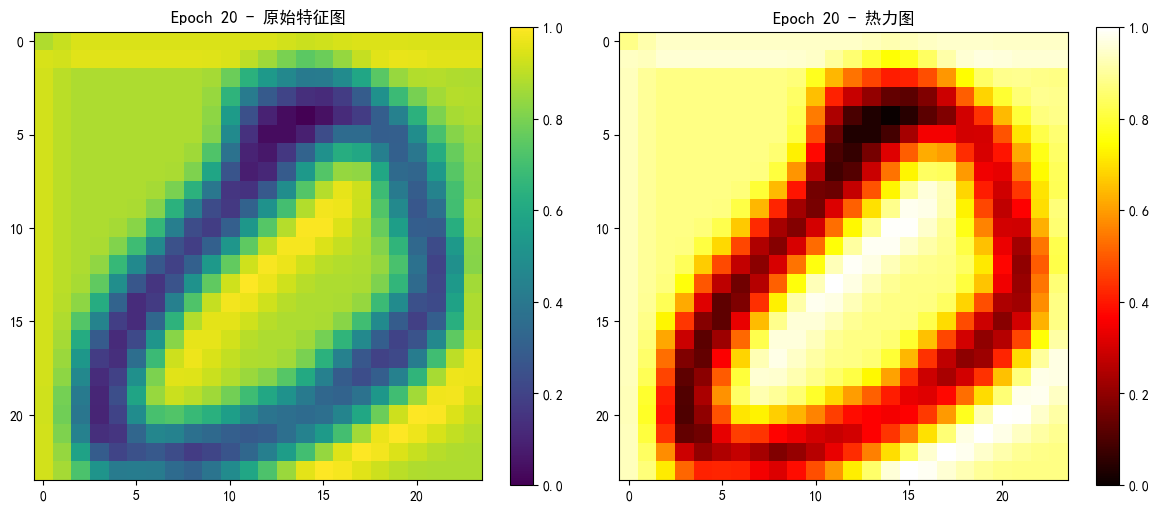

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_20.png
Epoch 21/500: Train Loss: 0.7338 | Val Loss: 0.7326 | Train Top-1: 0.7826 | Val Top-1: 0.7757 | Train Top-3: 0.9349 | Val Top-3: 0.9332
🎯 新最佳模型 (准确率: 0.7836) 已保存到 best_model_LeNet5.pth
Epoch 22/500: Train Loss: 0.7218 | Val Loss: 0.7124 | Train Top-1: 0.7885 | Val Top-1: 0.7836 | Train Top-3: 0.9375 | Val Top-3: 0.9375
🎯 新最佳模型 (准确率: 0.7910) 已保存到 best_model_LeNet5.pth
Epoch 23/500: Train Loss: 0.6952 | Val Loss: 0.6848 | Train Top-1: 0.7933 | Val Top-1: 0.7910 | Train Top-3: 0.9386 | Val Top-3: 0.9413
🎯 新最佳模型 (准确率: 0.7941) 已保存到 best_model_LeNet5.pth
Epoch 24/500: Train Loss: 0.6818 | Val Loss: 0.6759 | Train Top-1: 0.7972 | Val Top-1: 0.7941 | Train Top-3: 0.9417 | Val Top-3: 0.9395
🎯 新最佳模型 (准确率: 0.8023) 已保存到 best_model_LeNet5.pth
Epoch 25/500: Train Loss: 0.6727 | Val Loss: 0.6660 | Train Top-1: 0.8014 | Val Top-1: 0.8023 | Train Top-3: 0.9429 | Val Top-3: 0.9427


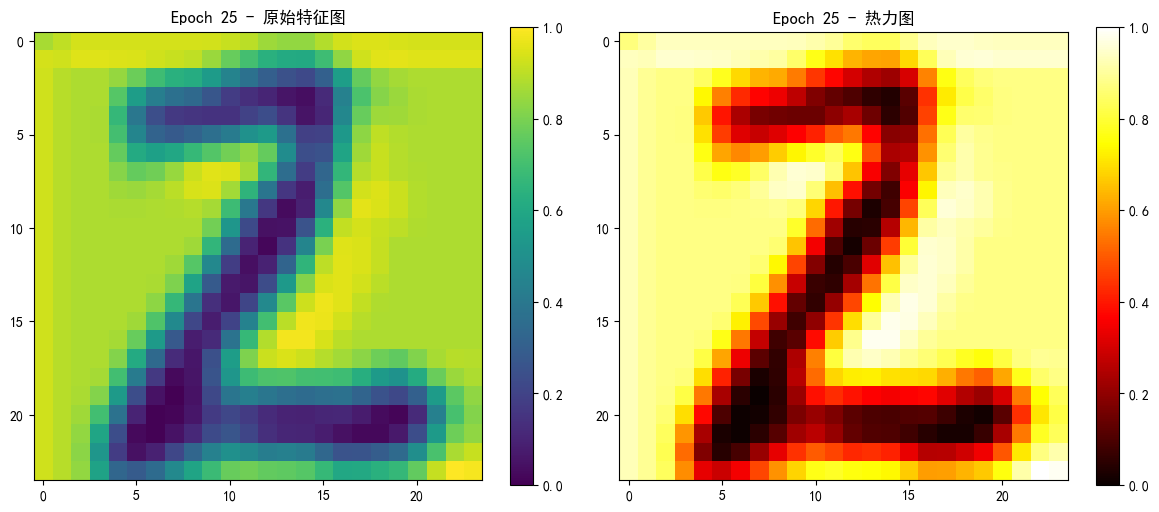

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_25.png
🎯 新最佳模型 (准确率: 0.8058) 已保存到 best_model_LeNet5.pth
Epoch 26/500: Train Loss: 0.6544 | Val Loss: 0.6611 | Train Top-1: 0.8056 | Val Top-1: 0.8058 | Train Top-3: 0.9454 | Val Top-3: 0.9411
Epoch 27/500: Train Loss: 0.6416 | Val Loss: 0.6698 | Train Top-1: 0.8105 | Val Top-1: 0.7971 | Train Top-3: 0.9477 | Val Top-3: 0.9422
🎯 新最佳模型 (准确率: 0.8094) 已保存到 best_model_LeNet5.pth
Epoch 28/500: Train Loss: 0.6295 | Val Loss: 0.6317 | Train Top-1: 0.8127 | Val Top-1: 0.8094 | Train Top-3: 0.9492 | Val Top-3: 0.9490
Epoch 29/500: Train Loss: 0.6160 | Val Loss: 0.6178 | Train Top-1: 0.8140 | Val Top-1: 0.8085 | Train Top-3: 0.9509 | Val Top-3: 0.9497
🎯 新最佳模型 (准确率: 0.8126) 已保存到 best_model_LeNet5.pth
Epoch 30/500: Train Loss: 0.6086 | Val Loss: 0.6066 | Train Top-1: 0.8190 | Val Top-1: 0.8126 | Train Top-3: 0.9515 | Val Top-3: 0.9517


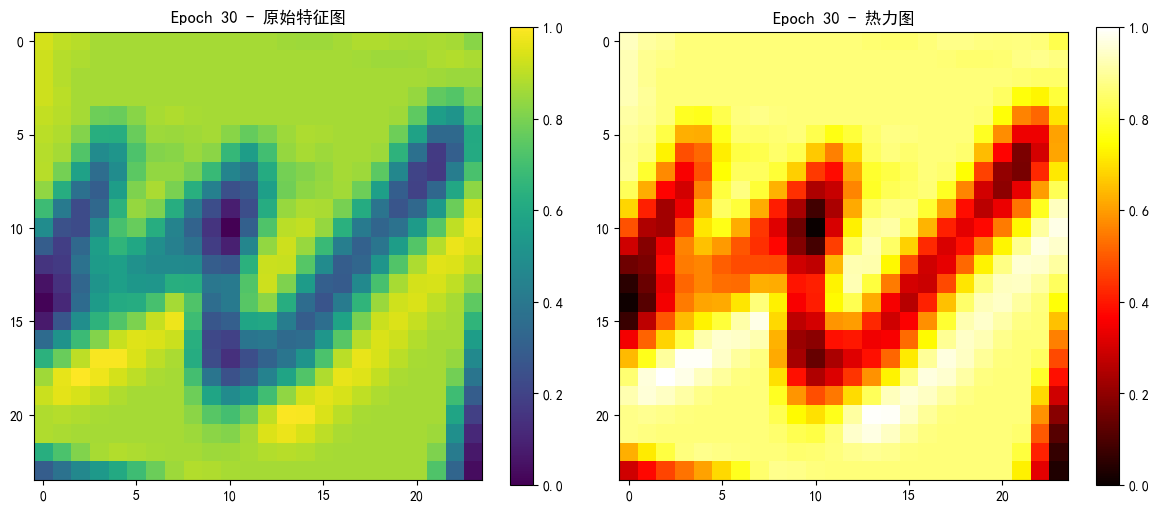

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_30.png
🎯 新最佳模型 (准确率: 0.8187) 已保存到 best_model_LeNet5.pth
Epoch 31/500: Train Loss: 0.5969 | Val Loss: 0.6080 | Train Top-1: 0.8217 | Val Top-1: 0.8187 | Train Top-3: 0.9532 | Val Top-3: 0.9476
Epoch 32/500: Train Loss: 0.5909 | Val Loss: 0.6054 | Train Top-1: 0.8235 | Val Top-1: 0.8182 | Train Top-3: 0.9525 | Val Top-3: 0.9495
Epoch 33/500: Train Loss: 0.5784 | Val Loss: 0.5889 | Train Top-1: 0.8254 | Val Top-1: 0.8173 | Train Top-3: 0.9552 | Val Top-3: 0.9562
🎯 新最佳模型 (准确率: 0.8259) 已保存到 best_model_LeNet5.pth
Epoch 34/500: Train Loss: 0.5716 | Val Loss: 0.5744 | Train Top-1: 0.8290 | Val Top-1: 0.8259 | Train Top-3: 0.9551 | Val Top-3: 0.9555
🎯 新最佳模型 (准确率: 0.8263) 已保存到 best_model_LeNet5.pth
Epoch 35/500: Train Loss: 0.5654 | Val Loss: 0.5594 | Train Top-1: 0.8314 | Val Top-1: 0.8263 | Train Top-3: 0.9567 | Val Top-3: 0.9559


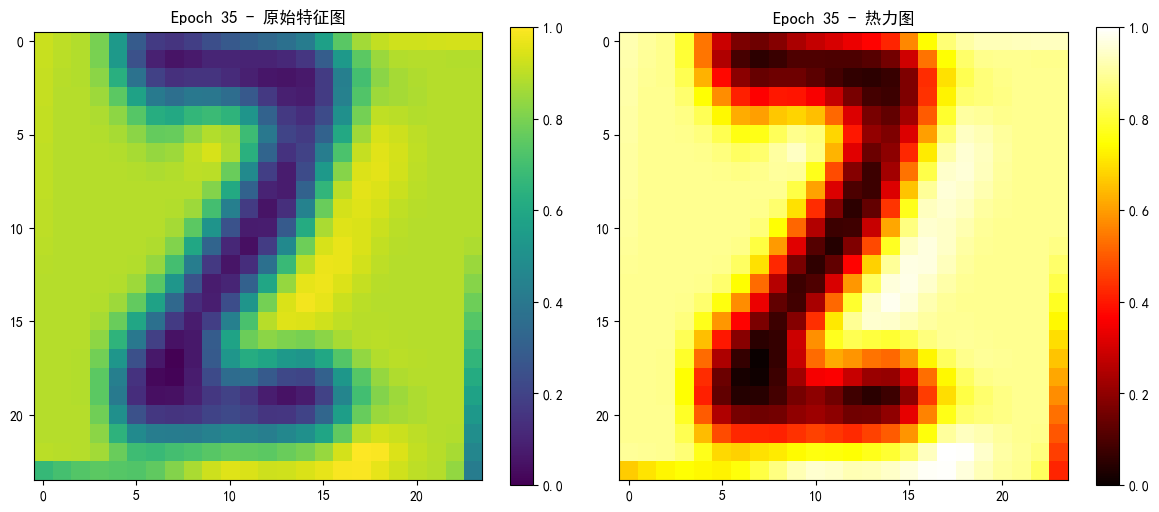

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_35.png
🎯 新最佳模型 (准确率: 0.8312) 已保存到 best_model_LeNet5.pth
Epoch 36/500: Train Loss: 0.5617 | Val Loss: 0.5608 | Train Top-1: 0.8307 | Val Top-1: 0.8312 | Train Top-3: 0.9576 | Val Top-3: 0.9548
🎯 新最佳模型 (准确率: 0.8348) 已保存到 best_model_LeNet5.pth
Epoch 37/500: Train Loss: 0.5525 | Val Loss: 0.5566 | Train Top-1: 0.8331 | Val Top-1: 0.8348 | Train Top-3: 0.9575 | Val Top-3: 0.9575
Epoch 38/500: Train Loss: 0.5463 | Val Loss: 0.5521 | Train Top-1: 0.8349 | Val Top-1: 0.8346 | Train Top-3: 0.9595 | Val Top-3: 0.9587
Epoch 39/500: Train Loss: 0.5389 | Val Loss: 0.5525 | Train Top-1: 0.8365 | Val Top-1: 0.8295 | Train Top-3: 0.9588 | Val Top-3: 0.9559
Epoch 40/500: Train Loss: 0.5287 | Val Loss: 0.5499 | Train Top-1: 0.8386 | Val Top-1: 0.8270 | Train Top-3: 0.9622 | Val Top-3: 0.9598


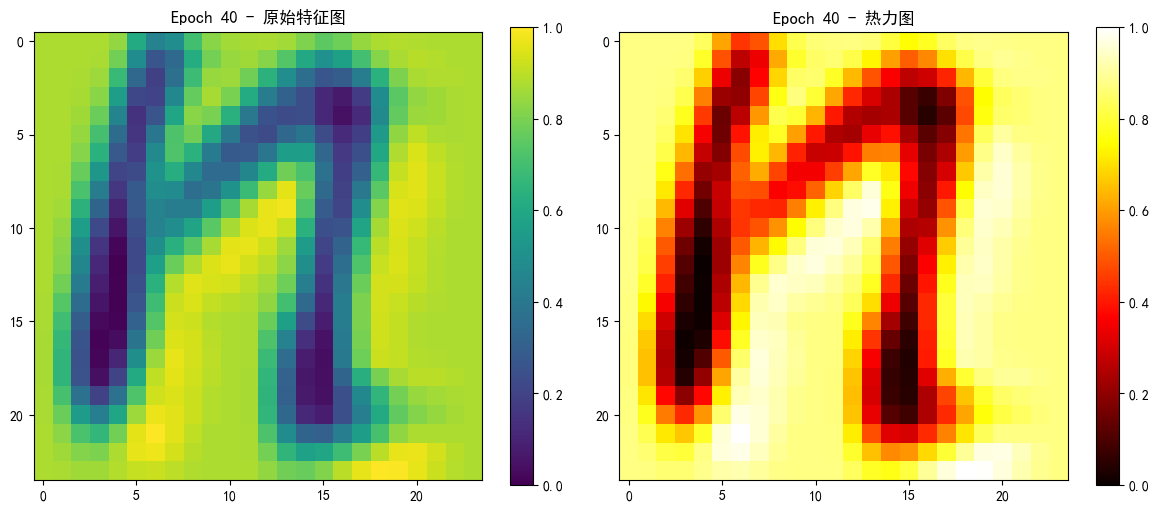

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_40.png
🎯 新最佳模型 (准确率: 0.8360) 已保存到 best_model_LeNet5.pth
Epoch 41/500: Train Loss: 0.5247 | Val Loss: 0.5499 | Train Top-1: 0.8407 | Val Top-1: 0.8360 | Train Top-3: 0.9623 | Val Top-3: 0.9578
🎯 新最佳模型 (准确率: 0.8393) 已保存到 best_model_LeNet5.pth
Epoch 42/500: Train Loss: 0.5212 | Val Loss: 0.5321 | Train Top-1: 0.8424 | Val Top-1: 0.8393 | Train Top-3: 0.9627 | Val Top-3: 0.9631
🎯 新最佳模型 (准确率: 0.8409) 已保存到 best_model_LeNet5.pth
Epoch 43/500: Train Loss: 0.5116 | Val Loss: 0.5248 | Train Top-1: 0.8462 | Val Top-1: 0.8409 | Train Top-3: 0.9625 | Val Top-3: 0.9620
Epoch 44/500: Train Loss: 0.5101 | Val Loss: 0.5315 | Train Top-1: 0.8442 | Val Top-1: 0.8386 | Train Top-3: 0.9635 | Val Top-3: 0.9595
Epoch 45/500: Train Loss: 0.4988 | Val Loss: 0.5091 | Train Top-1: 0.8456 | Val Top-1: 0.8389 | Train Top-3: 0.9654 | Val Top-3: 0.9647


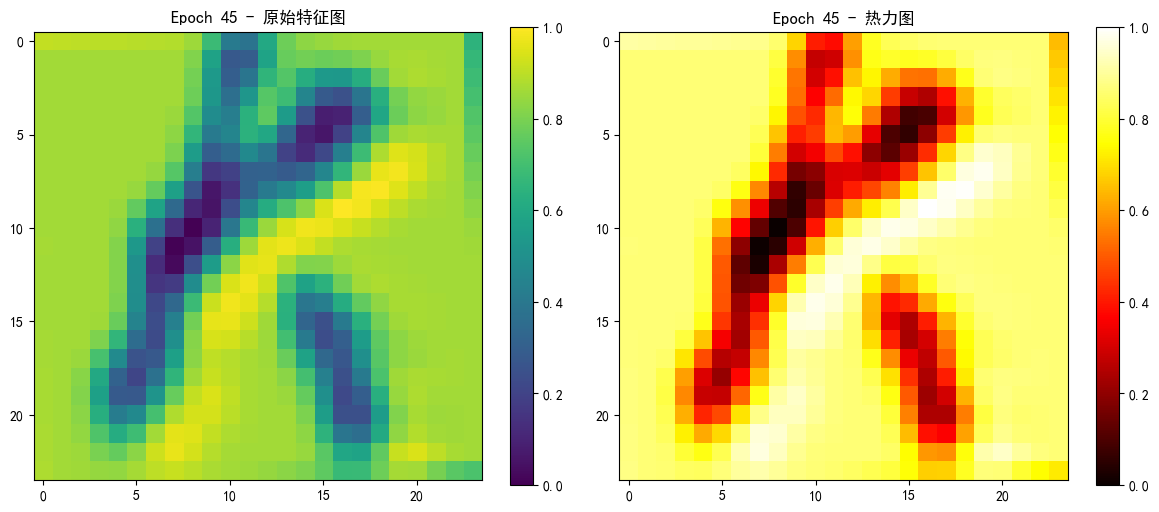

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_45.png
Epoch 46/500: Train Loss: 0.4976 | Val Loss: 0.5273 | Train Top-1: 0.8482 | Val Top-1: 0.8386 | Train Top-3: 0.9637 | Val Top-3: 0.9618
🎯 新最佳模型 (准确率: 0.8477) 已保存到 best_model_LeNet5.pth
Epoch 47/500: Train Loss: 0.4920 | Val Loss: 0.5123 | Train Top-1: 0.8498 | Val Top-1: 0.8477 | Train Top-3: 0.9664 | Val Top-3: 0.9638
Epoch 48/500: Train Loss: 0.4902 | Val Loss: 0.5065 | Train Top-1: 0.8488 | Val Top-1: 0.8449 | Train Top-3: 0.9661 | Val Top-3: 0.9623
Epoch 49/500: Train Loss: 0.4805 | Val Loss: 0.4911 | Train Top-1: 0.8528 | Val Top-1: 0.8458 | Train Top-3: 0.9672 | Val Top-3: 0.9629
Epoch 50/500: Train Loss: 0.4785 | Val Loss: 0.4985 | Train Top-1: 0.8541 | Val Top-1: 0.8429 | Train Top-3: 0.9672 | Val Top-3: 0.9607


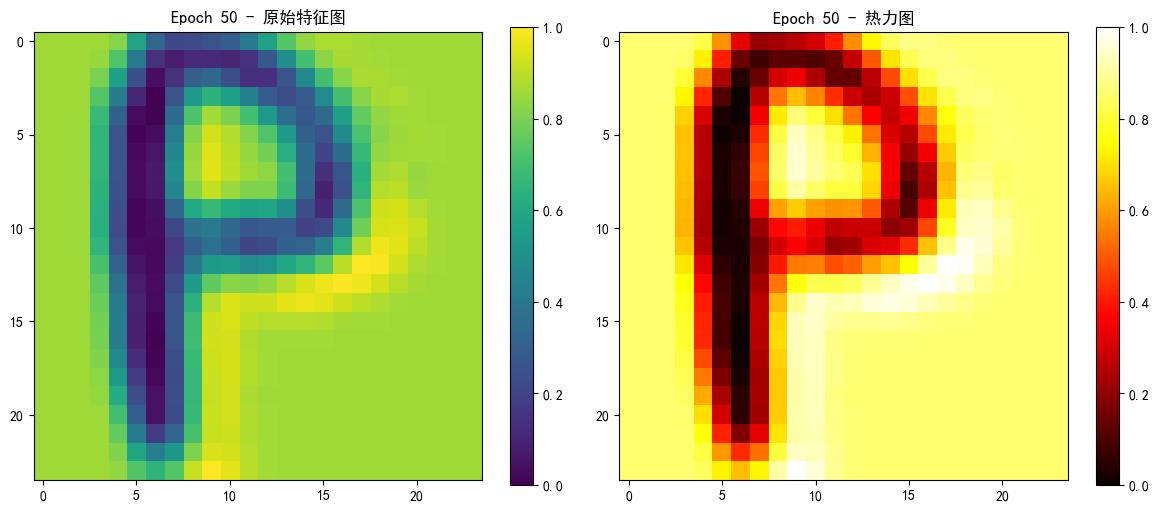

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_50.png
Epoch 51/500: Train Loss: 0.4737 | Val Loss: 0.5052 | Train Top-1: 0.8552 | Val Top-1: 0.8468 | Train Top-3: 0.9678 | Val Top-3: 0.9623
Epoch 52/500: Train Loss: 0.4705 | Val Loss: 0.5035 | Train Top-1: 0.8578 | Val Top-1: 0.8414 | Train Top-3: 0.9683 | Val Top-3: 0.9643
Epoch 53/500: Train Loss: 0.4645 | Val Loss: 0.4949 | Train Top-1: 0.8581 | Val Top-1: 0.8474 | Train Top-3: 0.9695 | Val Top-3: 0.9643
Epoch 54/500: Train Loss: 0.4635 | Val Loss: 0.4930 | Train Top-1: 0.8588 | Val Top-1: 0.8447 | Train Top-3: 0.9690 | Val Top-3: 0.9638
Epoch 55/500: Train Loss: 0.4605 | Val Loss: 0.4960 | Train Top-1: 0.8581 | Val Top-1: 0.8443 | Train Top-3: 0.9693 | Val Top-3: 0.9656


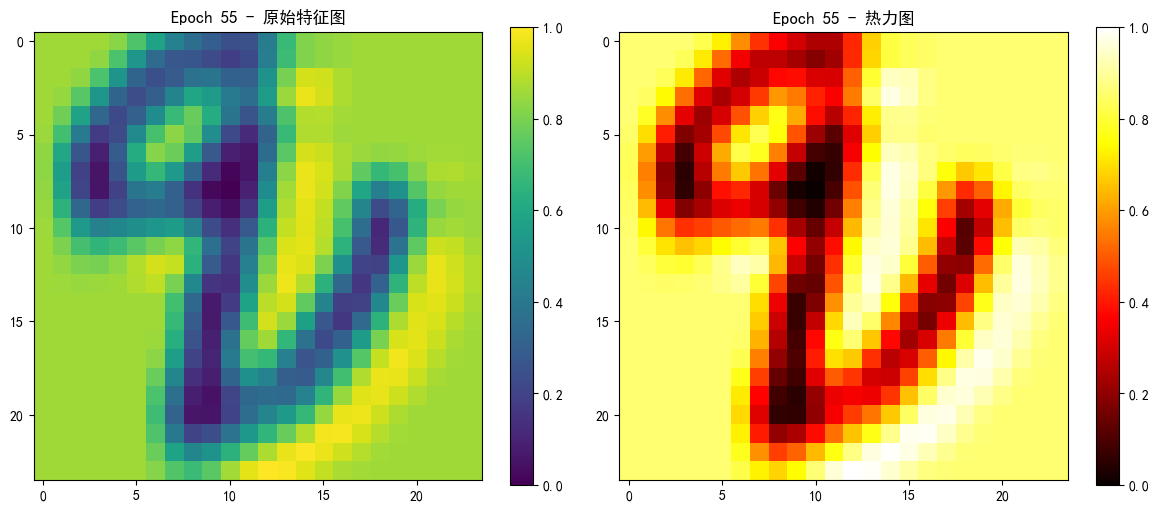

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_55.png
🎯 新最佳模型 (准确率: 0.8560) 已保存到 best_model_LeNet5.pth
Epoch 56/500: Train Loss: 0.4564 | Val Loss: 0.4719 | Train Top-1: 0.8588 | Val Top-1: 0.8560 | Train Top-3: 0.9695 | Val Top-3: 0.9672
Epoch 57/500: Train Loss: 0.4518 | Val Loss: 0.4826 | Train Top-1: 0.8610 | Val Top-1: 0.8508 | Train Top-3: 0.9701 | Val Top-3: 0.9645
Epoch 58/500: Train Loss: 0.4481 | Val Loss: 0.4780 | Train Top-1: 0.8628 | Val Top-1: 0.8497 | Train Top-3: 0.9699 | Val Top-3: 0.9665
🎯 新最佳模型 (准确率: 0.8566) 已保存到 best_model_LeNet5.pth
Epoch 59/500: Train Loss: 0.4407 | Val Loss: 0.4569 | Train Top-1: 0.8640 | Val Top-1: 0.8566 | Train Top-3: 0.9710 | Val Top-3: 0.9683
Epoch 60/500: Train Loss: 0.4395 | Val Loss: 0.4593 | Train Top-1: 0.8657 | Val Top-1: 0.8564 | Train Top-3: 0.9722 | Val Top-3: 0.9683


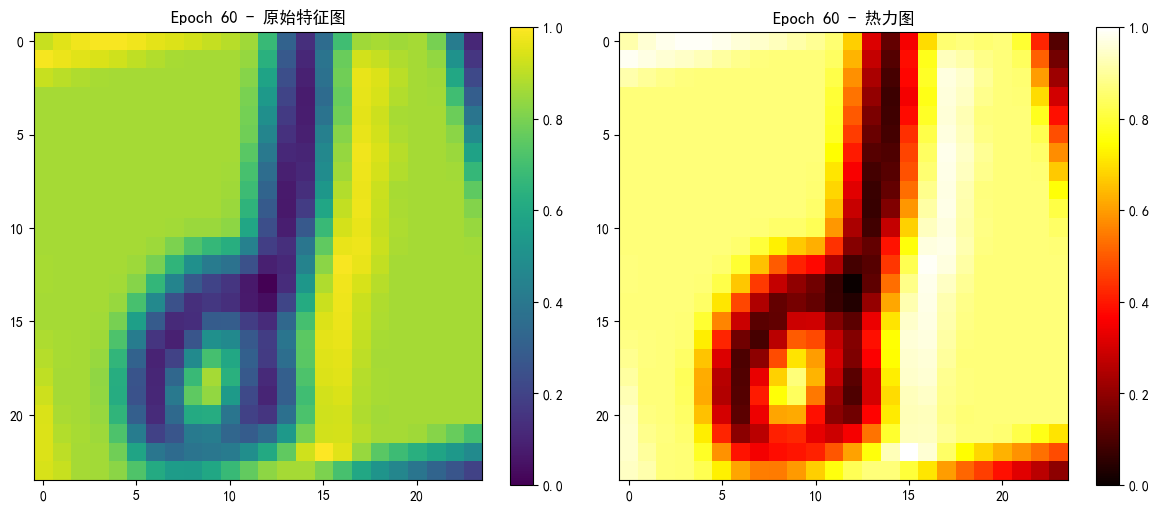

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_60.png
Epoch 61/500: Train Loss: 0.4403 | Val Loss: 0.4673 | Train Top-1: 0.8650 | Val Top-1: 0.8562 | Train Top-3: 0.9721 | Val Top-3: 0.9665
Epoch 62/500: Train Loss: 0.4335 | Val Loss: 0.4711 | Train Top-1: 0.8669 | Val Top-1: 0.8551 | Train Top-3: 0.9725 | Val Top-3: 0.9661
Epoch 63/500: Train Loss: 0.4268 | Val Loss: 0.4799 | Train Top-1: 0.8682 | Val Top-1: 0.8485 | Train Top-3: 0.9725 | Val Top-3: 0.9668
Epoch 64/500: Train Loss: 0.4309 | Val Loss: 0.4552 | Train Top-1: 0.8665 | Val Top-1: 0.8530 | Train Top-3: 0.9721 | Val Top-3: 0.9688
🎯 新最佳模型 (准确率: 0.8569) 已保存到 best_model_LeNet5.pth
Epoch 65/500: Train Loss: 0.4282 | Val Loss: 0.4492 | Train Top-1: 0.8671 | Val Top-1: 0.8569 | Train Top-3: 0.9729 | Val Top-3: 0.9668


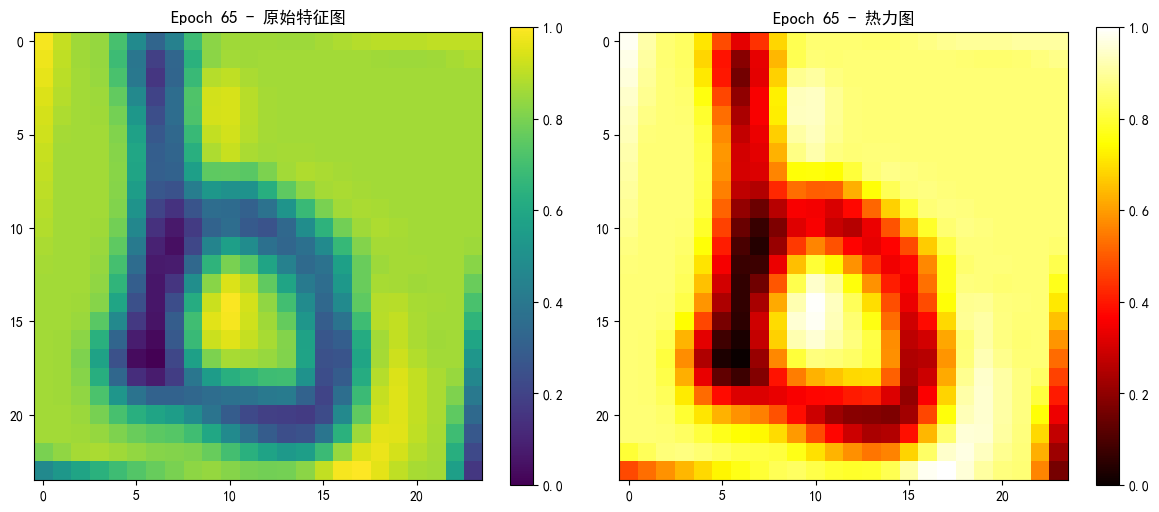

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_65.png
Epoch 66/500: Train Loss: 0.4274 | Val Loss: 0.4732 | Train Top-1: 0.8659 | Val Top-1: 0.8535 | Train Top-3: 0.9722 | Val Top-3: 0.9658
🎯 新最佳模型 (准确率: 0.8605) 已保存到 best_model_LeNet5.pth
Epoch 67/500: Train Loss: 0.4172 | Val Loss: 0.4606 | Train Top-1: 0.8703 | Val Top-1: 0.8605 | Train Top-3: 0.9739 | Val Top-3: 0.9670
Epoch 68/500: Train Loss: 0.4167 | Val Loss: 0.4552 | Train Top-1: 0.8704 | Val Top-1: 0.8604 | Train Top-3: 0.9759 | Val Top-3: 0.9692
🎯 新最佳模型 (准确率: 0.8640) 已保存到 best_model_LeNet5.pth
Epoch 69/500: Train Loss: 0.4146 | Val Loss: 0.4514 | Train Top-1: 0.8718 | Val Top-1: 0.8640 | Train Top-3: 0.9744 | Val Top-3: 0.9667
Epoch 70/500: Train Loss: 0.4113 | Val Loss: 0.4552 | Train Top-1: 0.8712 | Val Top-1: 0.8580 | Train Top-3: 0.9745 | Val Top-3: 0.9701


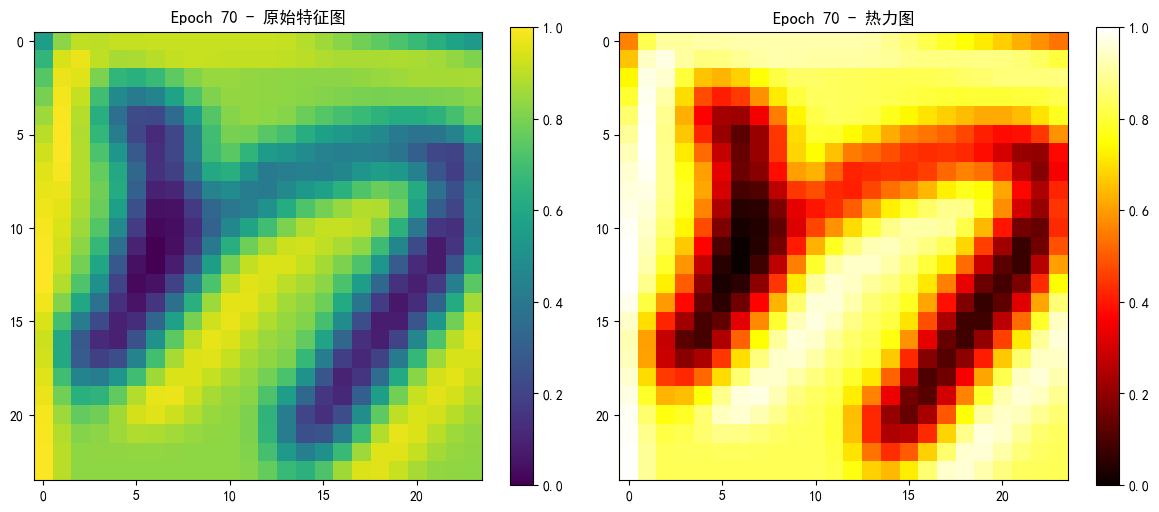

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_70.png
Epoch 71/500: Train Loss: 0.4081 | Val Loss: 0.4415 | Train Top-1: 0.8737 | Val Top-1: 0.8596 | Train Top-3: 0.9743 | Val Top-3: 0.9695
Epoch 72/500: Train Loss: 0.4013 | Val Loss: 0.4393 | Train Top-1: 0.8754 | Val Top-1: 0.8629 | Train Top-3: 0.9756 | Val Top-3: 0.9688
Epoch 73/500: Train Loss: 0.4033 | Val Loss: 0.4453 | Train Top-1: 0.8736 | Val Top-1: 0.8569 | Train Top-3: 0.9755 | Val Top-3: 0.9685
Epoch 74/500: Train Loss: 0.4018 | Val Loss: 0.4441 | Train Top-1: 0.8734 | Val Top-1: 0.8620 | Train Top-3: 0.9770 | Val Top-3: 0.9695
Epoch 75/500: Train Loss: 0.4027 | Val Loss: 0.4280 | Train Top-1: 0.8753 | Val Top-1: 0.8636 | Train Top-3: 0.9754 | Val Top-3: 0.9728


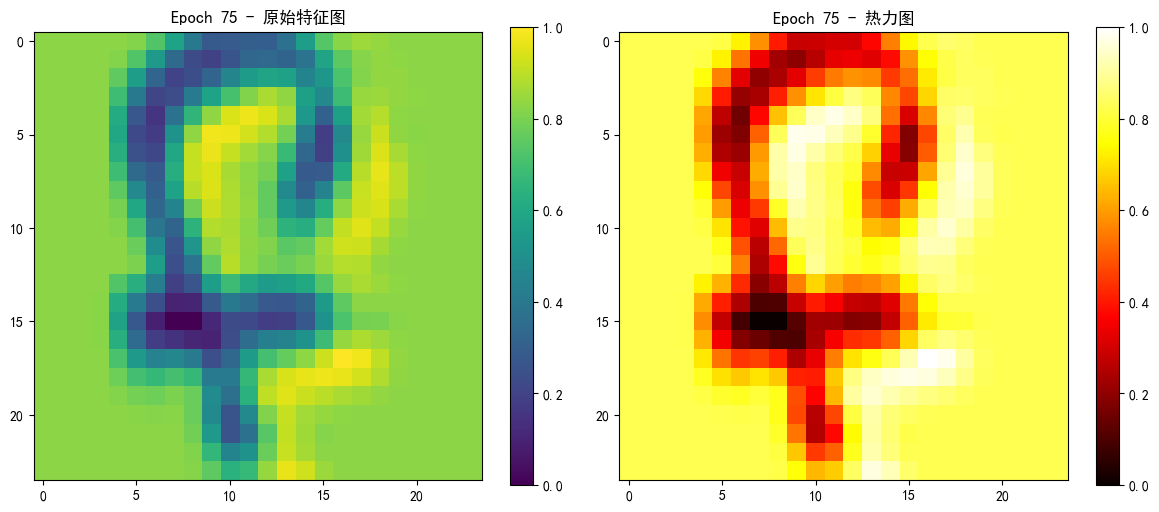

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_75.png
Epoch 76/500: Train Loss: 0.4024 | Val Loss: 0.4451 | Train Top-1: 0.8754 | Val Top-1: 0.8602 | Train Top-3: 0.9762 | Val Top-3: 0.9695
Epoch 77/500: Train Loss: 0.3931 | Val Loss: 0.4462 | Train Top-1: 0.8758 | Val Top-1: 0.8622 | Train Top-3: 0.9764 | Val Top-3: 0.9688
🎯 新最佳模型 (准确率: 0.8686) 已保存到 best_model_LeNet5.pth
Epoch 78/500: Train Loss: 0.3961 | Val Loss: 0.4306 | Train Top-1: 0.8755 | Val Top-1: 0.8686 | Train Top-3: 0.9759 | Val Top-3: 0.9714
Epoch 79/500: Train Loss: 0.3890 | Val Loss: 0.4310 | Train Top-1: 0.8766 | Val Top-1: 0.8674 | Train Top-3: 0.9781 | Val Top-3: 0.9708
Epoch 80/500: Train Loss: 0.3900 | Val Loss: 0.4323 | Train Top-1: 0.8786 | Val Top-1: 0.8649 | Train Top-3: 0.9773 | Val Top-3: 0.9723


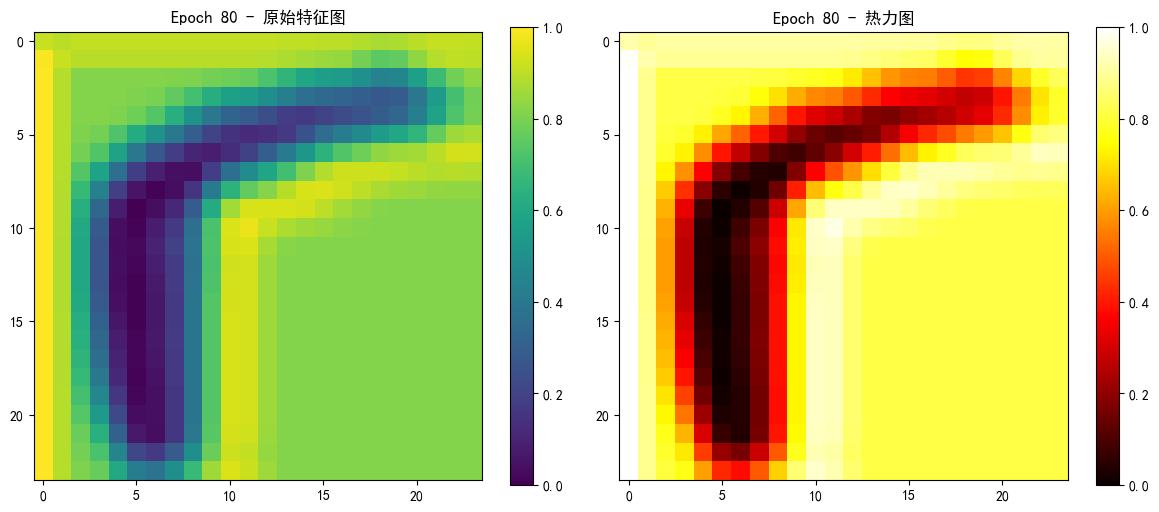

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_80.png
Epoch 81/500: Train Loss: 0.3841 | Val Loss: 0.4393 | Train Top-1: 0.8808 | Val Top-1: 0.8600 | Train Top-3: 0.9772 | Val Top-3: 0.9706
Epoch 82/500: Train Loss: 0.3884 | Val Loss: 0.4316 | Train Top-1: 0.8769 | Val Top-1: 0.8656 | Train Top-3: 0.9776 | Val Top-3: 0.9699
Epoch 83/500: Train Loss: 0.3812 | Val Loss: 0.4267 | Train Top-1: 0.8789 | Val Top-1: 0.8645 | Train Top-3: 0.9775 | Val Top-3: 0.9728
Epoch 84/500: Train Loss: 0.3745 | Val Loss: 0.4307 | Train Top-1: 0.8832 | Val Top-1: 0.8627 | Train Top-3: 0.9781 | Val Top-3: 0.9706
Epoch 85/500: Train Loss: 0.3760 | Val Loss: 0.4309 | Train Top-1: 0.8814 | Val Top-1: 0.8686 | Train Top-3: 0.9787 | Val Top-3: 0.9715


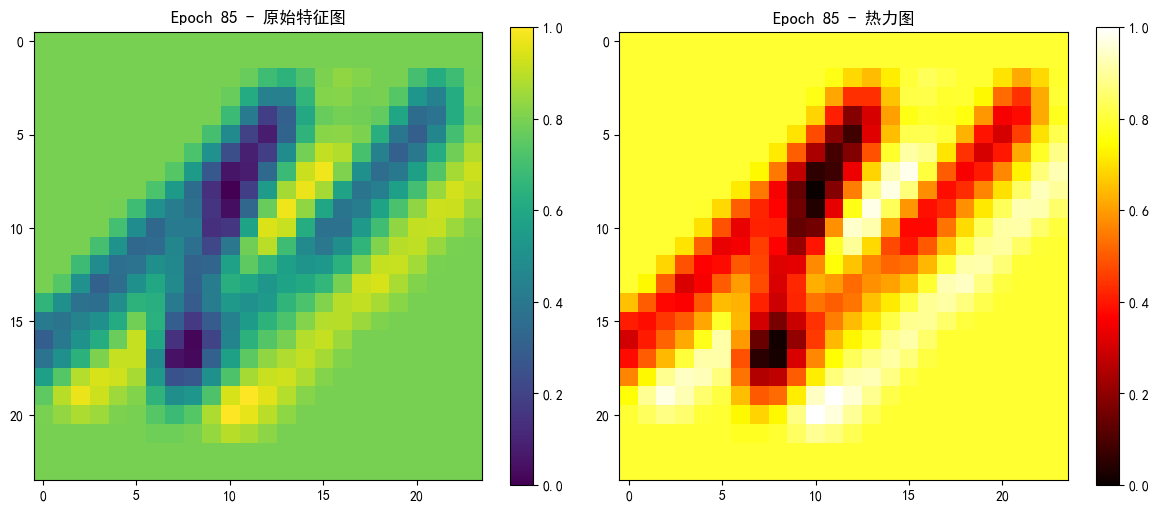

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_85.png
🎯 新最佳模型 (准确率: 0.8688) 已保存到 best_model_LeNet5.pth
Epoch 86/500: Train Loss: 0.3779 | Val Loss: 0.4215 | Train Top-1: 0.8813 | Val Top-1: 0.8688 | Train Top-3: 0.9784 | Val Top-3: 0.9732
Epoch 87/500: Train Loss: 0.3757 | Val Loss: 0.4253 | Train Top-1: 0.8804 | Val Top-1: 0.8674 | Train Top-3: 0.9784 | Val Top-3: 0.9726
Epoch 88/500: Train Loss: 0.3700 | Val Loss: 0.4229 | Train Top-1: 0.8822 | Val Top-1: 0.8681 | Train Top-3: 0.9787 | Val Top-3: 0.9719
🎯 新最佳模型 (准确率: 0.8728) 已保存到 best_model_LeNet5.pth
Epoch 89/500: Train Loss: 0.3703 | Val Loss: 0.4124 | Train Top-1: 0.8834 | Val Top-1: 0.8728 | Train Top-3: 0.9800 | Val Top-3: 0.9733
Epoch 90/500: Train Loss: 0.3696 | Val Loss: 0.4151 | Train Top-1: 0.8831 | Val Top-1: 0.8672 | Train Top-3: 0.9794 | Val Top-3: 0.9735


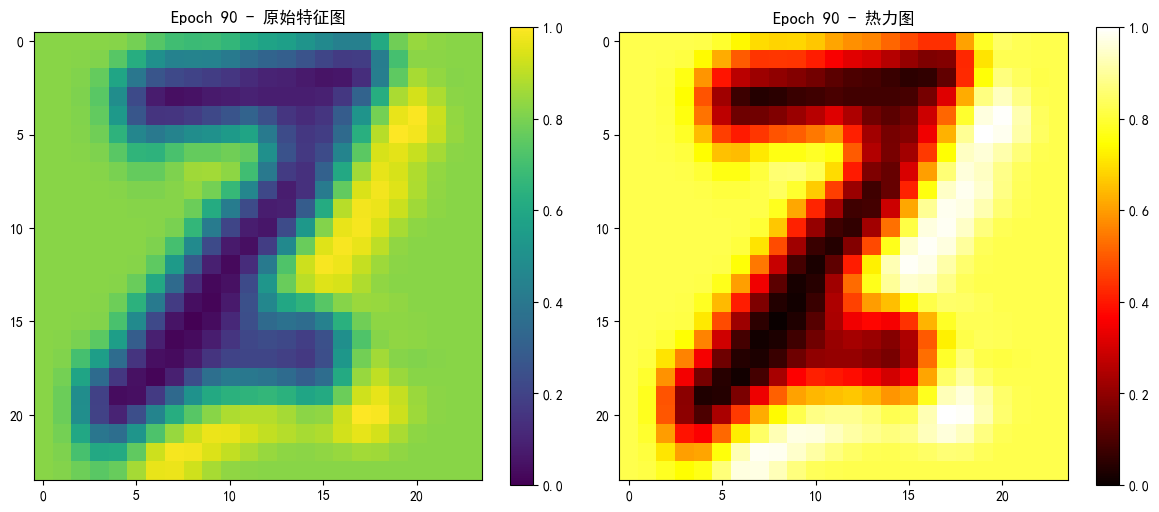

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_90.png
Epoch 91/500: Train Loss: 0.3732 | Val Loss: 0.4074 | Train Top-1: 0.8823 | Val Top-1: 0.8681 | Train Top-3: 0.9788 | Val Top-3: 0.9732
Epoch 92/500: Train Loss: 0.3611 | Val Loss: 0.4172 | Train Top-1: 0.8857 | Val Top-1: 0.8645 | Train Top-3: 0.9809 | Val Top-3: 0.9760
Epoch 93/500: Train Loss: 0.3640 | Val Loss: 0.4185 | Train Top-1: 0.8851 | Val Top-1: 0.8699 | Train Top-3: 0.9806 | Val Top-3: 0.9730
Epoch 94/500: Train Loss: 0.3598 | Val Loss: 0.4228 | Train Top-1: 0.8847 | Val Top-1: 0.8703 | Train Top-3: 0.9806 | Val Top-3: 0.9730
Epoch 95/500: Train Loss: 0.3556 | Val Loss: 0.4224 | Train Top-1: 0.8866 | Val Top-1: 0.8686 | Train Top-3: 0.9807 | Val Top-3: 0.9719


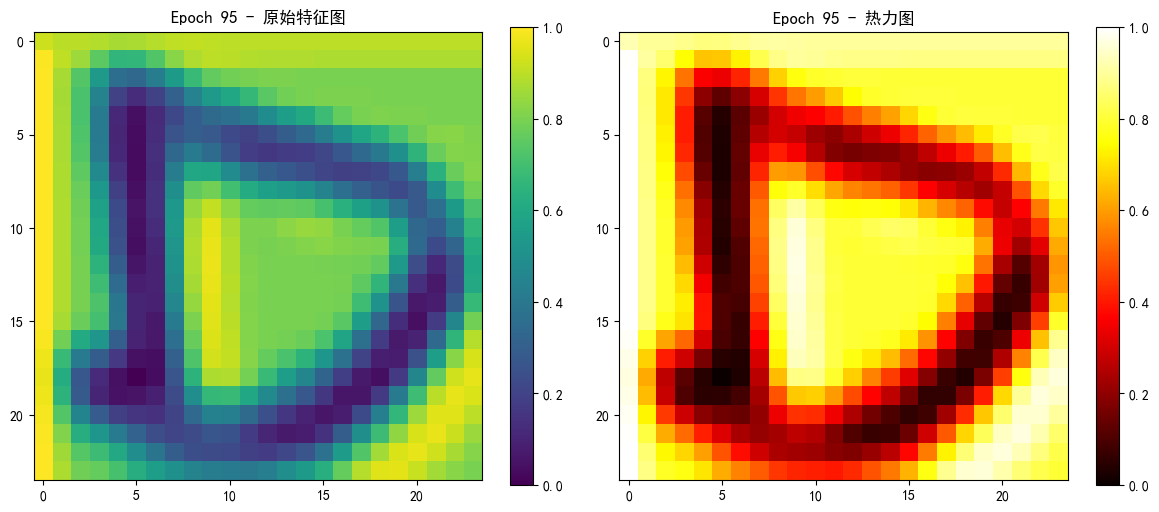

🖼️ 特征图已保存到: runs/20250424_164518\feature_map_epoch_95.png
Epoch 96/500: Train Loss: 0.3589 | Val Loss: 0.4127 | Train Top-1: 0.8855 | Val Top-1: 0.8724 | Train Top-3: 0.9804 | Val Top-3: 0.9737
Epoch 97/500: Train Loss: 0.3594 | Val Loss: 0.4193 | Train Top-1: 0.8864 | Val Top-1: 0.8705 | Train Top-3: 0.9801 | Val Top-3: 0.9708
Epoch 98/500: Train Loss: 0.3585 | Val Loss: 0.4081 | Train Top-1: 0.8852 | Val Top-1: 0.8706 | Train Top-3: 0.9801 | Val Top-3: 0.9741
⏹️ 早停触发: 验证准确率连续 10 轮未提升
✅ 特征图钩子已移除


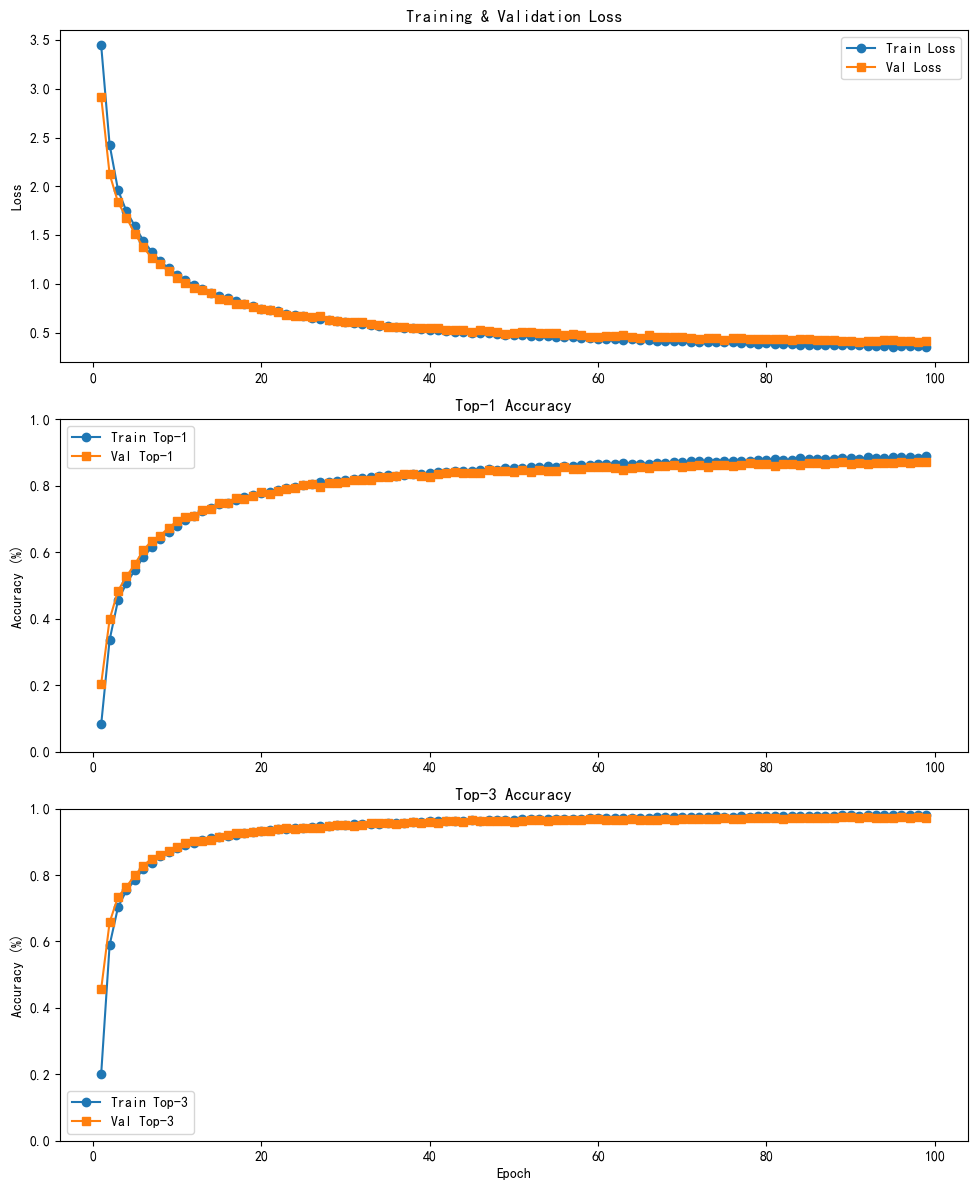

📊 训练图表已保存到: training_plots\training_metrics_20250424_171006.png


In [11]:
LeNet5 = train_and_validate(model=LeNet5,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCH,
    device=device,
    save_path="best_model_LeNet5.pth",
    lr=LR)

In [6]:
# 模型大小
model_size_resnet18 = sum(p.numel() for p in resnet18.parameters())/1000000
model_size_mobilenet_v2 = sum(p.numel() for p in mobilenet_v2.parameters())/1000000
model_size_LeNet5 = sum(p.numel() for p in LeNet5.parameters())/1000000
# 打印模型大小
print(f"ResNet18 Model Size: {model_size_resnet18}M parameters")
print(f"MobileNetV2 Model Size: {model_size_mobilenet_v2}M parameters")
print(f"LeNet5 Model Size: {model_size_LeNet5}M parameters")

model_sizes = [model_size_resnet18, model_size_mobilenet_v2, model_size_LeNet5]
model_names = ["ResNet18", "MobileNetV2", "LeNet5"]
top1_accs = []
top3_accs = []
f1_scores=[]
FPS_scores=[]
inference_speeds = []

ResNet18 Model Size: 11.195493M parameters
MobileNetV2 Model Size: 2.271269M parameters
LeNet5 Model Size: 0.047021M parameters


Confusion matrix, without normalization


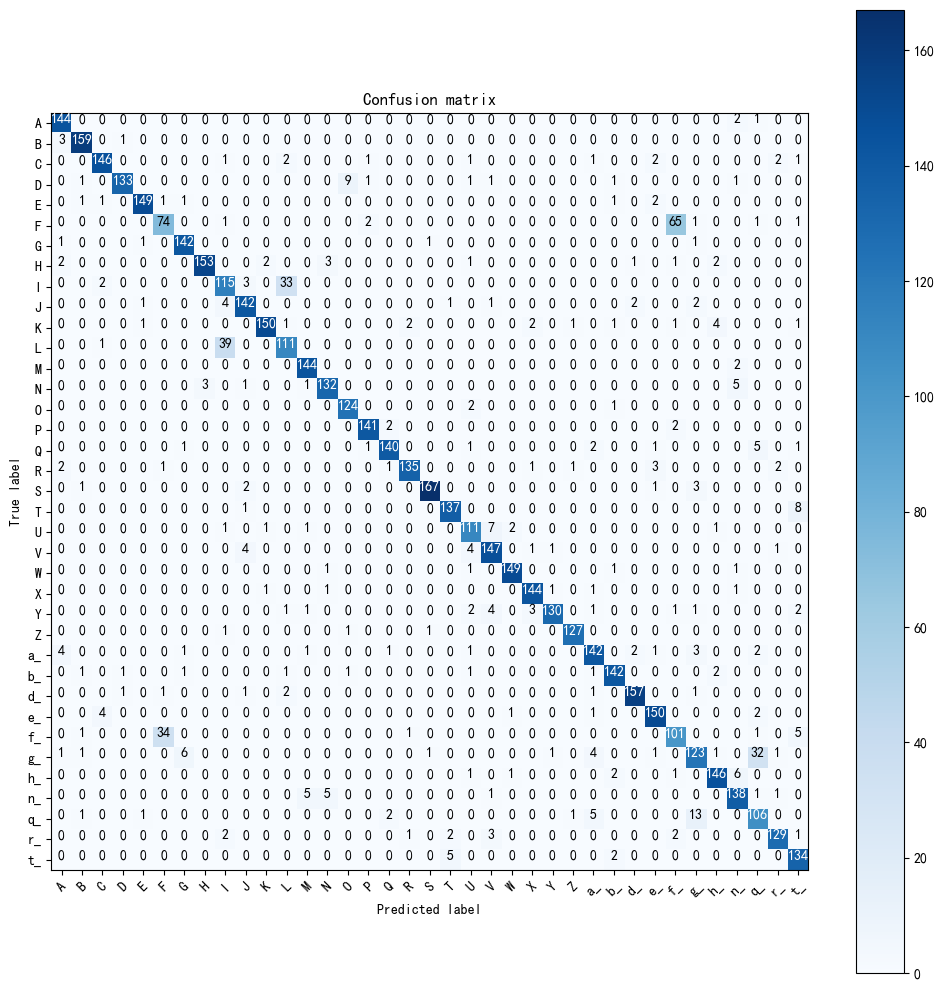

ResNet18 Evaluation:
Top-1 Accuracy: 90.3423
Top-3 Accuracy: 98.7387
F1 Score: 0.9034
FPS: 21463.87420265588
Inference Speed: 0.0466 ms per sample


In [7]:
# 推理
top1_acc_resnet18, top3_acc_resnet18,f1_score_resnet18,_,_, inference_speed_resnet18 = evaluate_model(resnet18, test_loader, device)
top1_accs.append(top1_acc_resnet18)
top3_accs.append(top3_acc_resnet18)
f1_scores.append(f1_score_resnet18)
FPS_scores.append(1/inference_speed_resnet18)
inference_speeds.append(inference_speed_resnet18*1000)
print("ResNet18 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_resnet18:.4f}")
print(f"Top-3 Accuracy: {top3_acc_resnet18:.4f}")
print(f"F1 Score: {f1_score_resnet18:.4f}")
print(f"FPS: {1/inference_speed_resnet18}")
print(f"Inference Speed: {inference_speed_resnet18 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


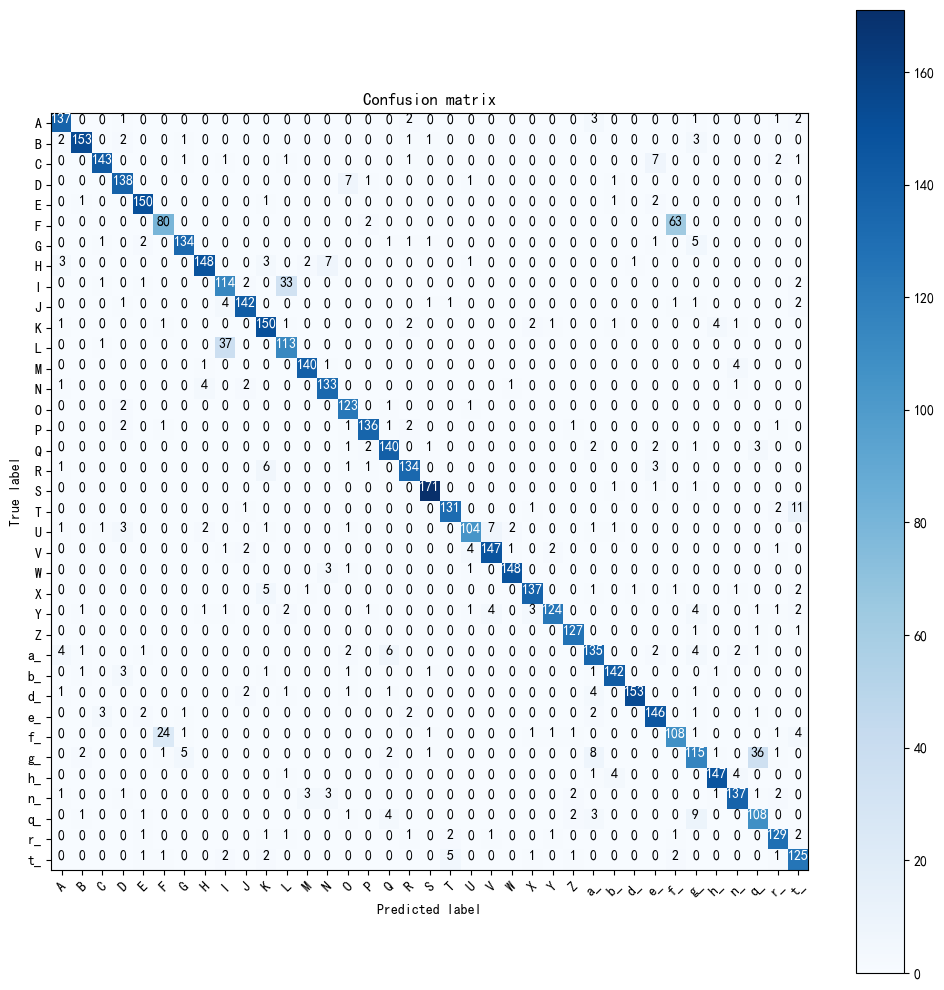

MobileNetV2 Evaluation:
Top-1 Accuracy: 89.0450
Top-3 Accuracy: 98.1261
F1 Score: 0.8903
FPS: 29107.15275311723
Inference Speed: 0.0344 ms per sample


In [8]:
top1_acc_mobilenetv2, top3_acc_mobilenetv2,f1_score_mobilenetv2,_,_, inference_speed_mobilenetv2 = evaluate_model(mobilenet_v2, test_loader, device)
top1_accs.append(top1_acc_mobilenetv2)
top3_accs.append(top3_acc_mobilenetv2)
f1_scores.append(f1_score_mobilenetv2)
FPS_scores.append(1/inference_speed_mobilenetv2)
inference_speeds.append(inference_speed_mobilenetv2*1000)
print("MobileNetV2 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_mobilenetv2:.4f}")
print(f"Top-3 Accuracy: {top3_acc_mobilenetv2:.4f}")
print(f"F1 Score: {f1_score_mobilenetv2:.4f}")
print(f"FPS: {1/inference_speed_mobilenetv2}")
print(f"Inference Speed: {inference_speed_mobilenetv2 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


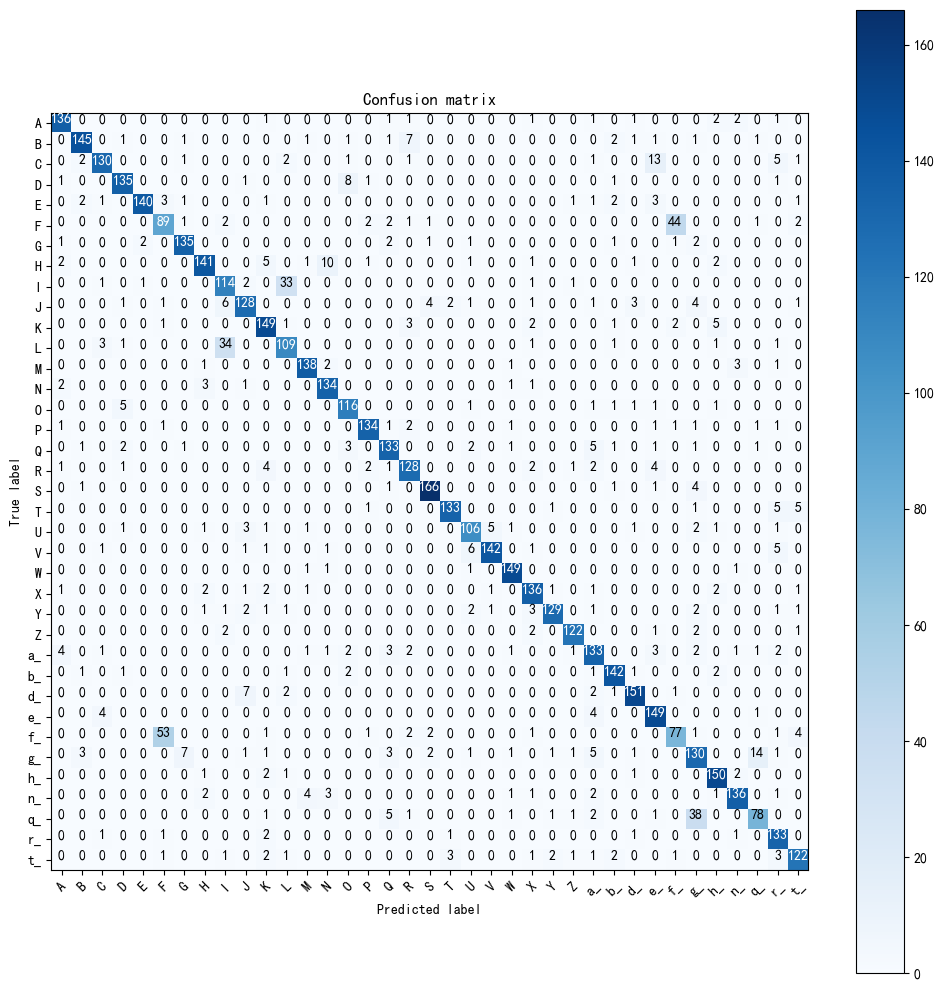

LeNet5 Evaluation:
Top-1 Accuracy: 86.8108
Top-3 Accuracy: 97.2252
F1 Score: 0.8677
FPS: 231932.6790678211
Inference Speed: 0.0043 ms per sample


In [9]:
top1_acc_LeNet5, top3_acc_LeNet5,f1_score_LeNet5,_,_, inference_speed_LeNet5 = evaluate_model(LeNet5, test_loader, device)
top1_accs.append(top1_acc_LeNet5)
top3_accs.append(top3_acc_LeNet5)
f1_scores.append(f1_score_LeNet5)
FPS_scores.append(1/inference_speed_LeNet5)
inference_speeds.append(inference_speed_LeNet5*1000)
print("LeNet5 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_LeNet5:.4f}")
print(f"Top-3 Accuracy: {top3_acc_LeNet5:.4f}")
print(f"F1 Score: {f1_score_LeNet5:.4f}")
print(f"FPS: {1/inference_speed_LeNet5}")
print(f"Inference Speed: {inference_speed_LeNet5 * 1000:.4f} ms per sample")

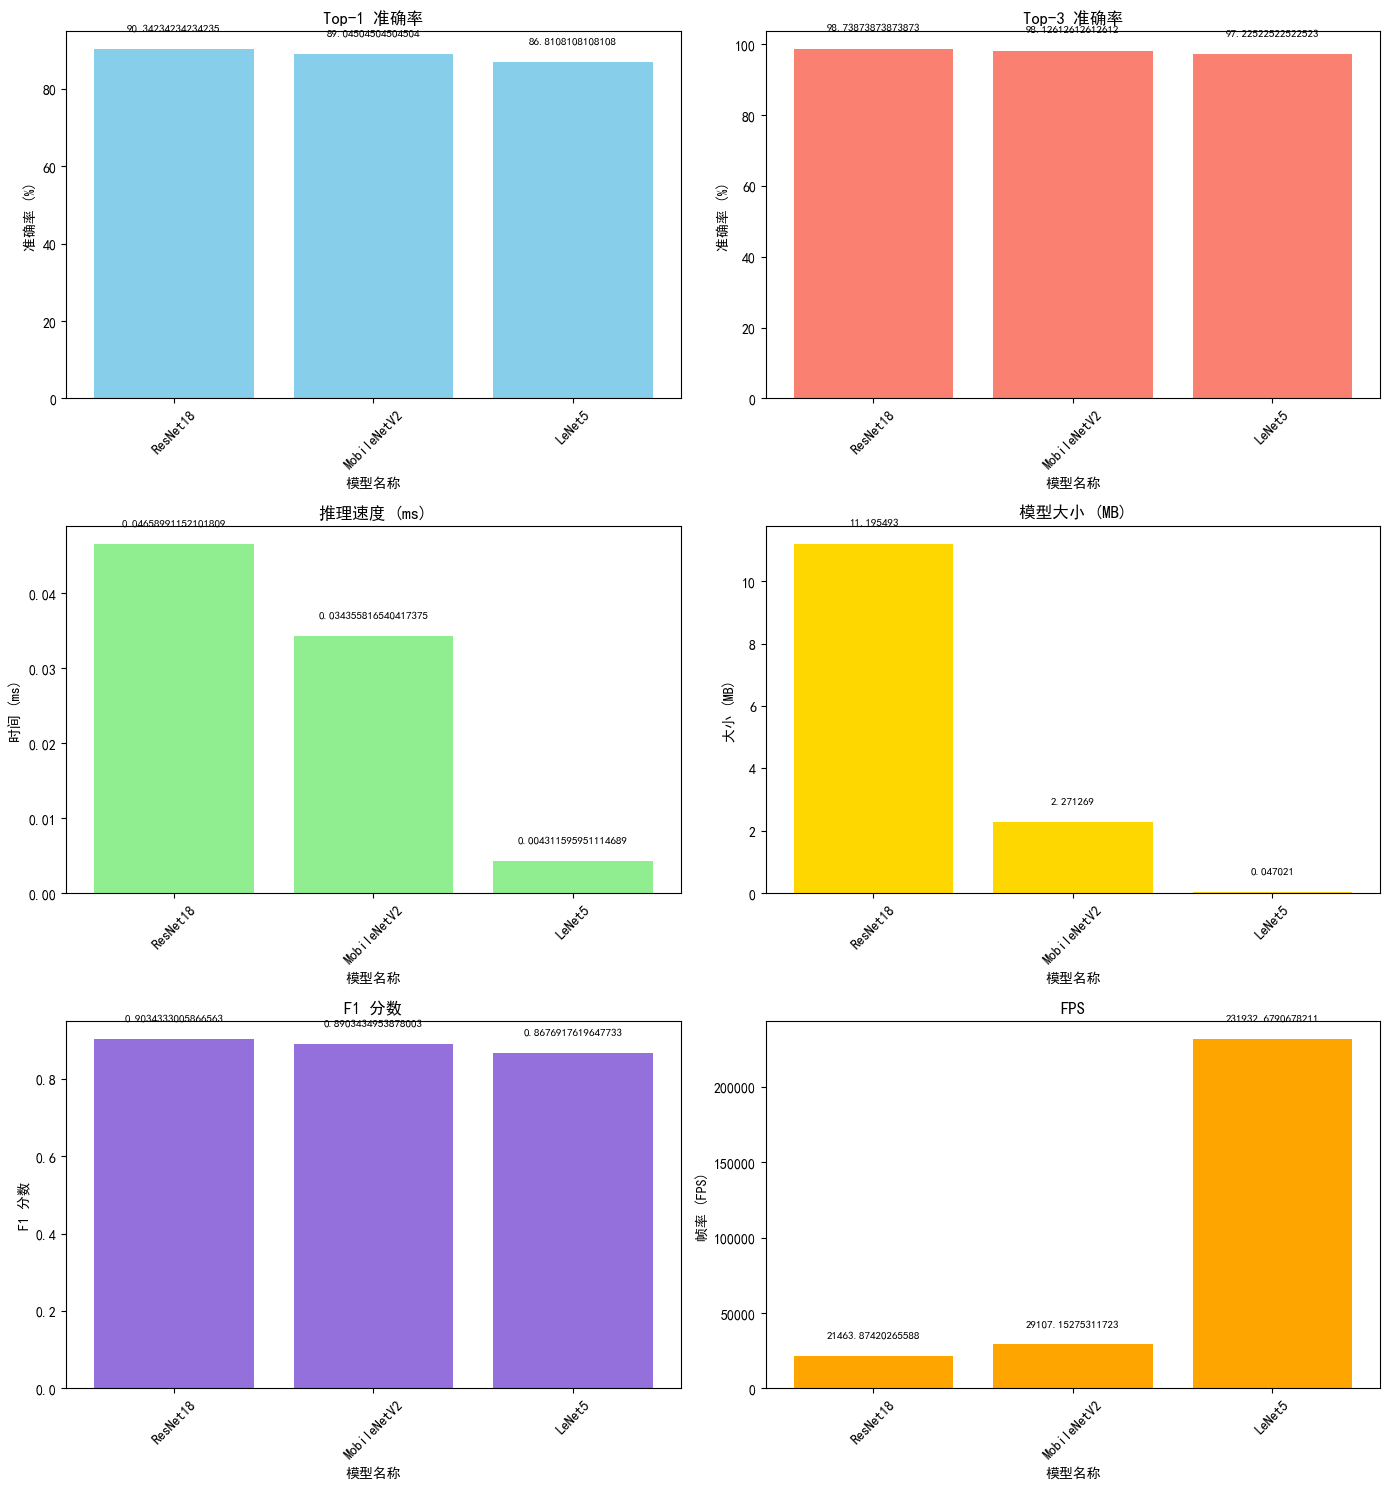

In [11]:
plot_comparison(model_names, top1_accs, top3_accs, inference_speeds, model_sizes, f1_scores, FPS_scores)


In [10]:
# 绘制图像对比top1、top3准确率、推理速度、模型大小
def plot_comparison(model_names, top1_accs, top3_accs, inference_speeds, model_sizes, f1_scores, fps_values):
    """
    绘制图像对比top1、top3准确率、推理速度、模型大小、F1分数和FPS，并标注具体数值

    参数:
    model_names (list): 模型名称列表
    top1_accs (list): Top-1 准确率列表
    top3_accs (list): Top-3 准确率列表
    inference_speeds (list): 推理速度列表
    model_sizes (list): 模型大小列表
    f1_scores (list): F1 分数列表
    fps_values (list): FPS 值列表
    """
    # 创建一个包含6个子图的图形 (3x2)
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))

    # 定义一个辅助函数用于添加数值标签
    def add_labels(ax, data):
        for i, value in enumerate(data):
            # 确保标签不会超出图像边框
            y_offset = max(data) * 0.05 if max(data) > 0 else 0.05
            ax.text(i, value + y_offset, f'{value}', ha='center', va='bottom', fontsize=8)

    # 绘制Top-1 准确率
    axs[0, 0].bar(model_names, top1_accs, color='skyblue')
    axs[0, 0].set_title('Top-1 准确率')
    axs[0, 0].set_ylabel('准确率 (%)')
    axs[0, 0].set_xlabel('模型名称')
    axs[0, 0].tick_params(axis='x', rotation=45)
    add_labels(axs[0, 0], top1_accs)

    # 绘制Top-3 准确率
    axs[0, 1].bar(model_names, top3_accs, color='salmon')
    axs[0, 1].set_title('Top-3 准确率')
    axs[0, 1].set_ylabel('准确率 (%)')
    axs[0, 1].set_xlabel('模型名称')
    axs[0, 1].tick_params(axis='x', rotation=45)
    add_labels(axs[0, 1], top3_accs)

    # 绘制推理速度
    axs[1, 0].bar(model_names, inference_speeds, color='lightgreen')
    axs[1, 0].set_title('推理速度 (ms)')
    axs[1, 0].set_ylabel('时间 (ms)')
    axs[1, 0].set_xlabel('模型名称')
    axs[1, 0].tick_params(axis='x', rotation=45)
    add_labels(axs[1, 0], inference_speeds)

    # 绘制模型大小
    axs[1, 1].bar(model_names, model_sizes, color='gold')
    axs[1, 1].set_title('模型大小 (MB)')
    axs[1, 1].set_ylabel('大小 (MB)')
    axs[1, 1].set_xlabel('模型名称')
    axs[1, 1].tick_params(axis='x', rotation=45)
    add_labels(axs[1, 1], model_sizes)

    # 绘制F1分数
    axs[2, 0].bar(model_names, f1_scores, color='mediumpurple')
    axs[2, 0].set_title('F1 分数')
    axs[2, 0].set_ylabel('F1 分数')
    axs[2, 0].set_xlabel('模型名称')
    axs[2, 0].tick_params(axis='x', rotation=45)
    add_labels(axs[2, 0], f1_scores)

    # 绘制FPS
    axs[2, 1].bar(model_names, fps_values, color='orange')
    axs[2, 1].set_title('FPS')
    axs[2, 1].set_ylabel('帧率 (FPS)')
    axs[2, 1].set_xlabel('模型名称')
    axs[2, 1].tick_params(axis='x', rotation=45)
    add_labels(axs[2, 1], fps_values)

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图形
    plt.show()